In [1]:
import numpy as np
import pickle as pkl
import time
import json
import random
import torch
from torch import nn
import editdistance
import os
import glob
from rnn.loader import make_loader, Preprocessor
from rnn.model import Seq2Seq
from rnn.model import LinearND 
from rnn.model import Attention
import matplotlib.pyplot as plt
np.seterr(divide='ignore') # masks log(0) errors

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [2]:
def compute_wer(results):
    """
    Compute the word-error-rate (WER).
    """
    dist = 0.
    for label, pred in results:
        dist += editdistance.eval(label, pred)
    total = sum(len(label) for label, _ in results)
    return dist / total

def train(model, optimizer, ldr):
    """
    Train the model for an epoch (one pass over the training data)
    ----
    model: Seq2Seq model instance
    optimizer: torch.nn optimizer instance
    ldr: data loader instance
    ----
    Returns the average loss over an epoch
    """
    model.train()
    model.scheduled_sampling = model.sample_prob != 0
    
    losses = []
    
    for ii, (inputs, labels) in enumerate(ldr):
        optimizer.zero_grad()
        x, y = model.collate(inputs, labels)
        loss = model.loss(x, y)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        losses.append(loss.data.item())
        
    return np.nanmean(losses)

def evaluate(model, ldr, preproc, store_prediction=False, print_prediction=False):
    """
    Evaluate the model (on either dev or test).
    ----
    model: Seq2Seq model instance
    ldr: data loader instance
    preproc: preprocessor instance
    ----
    Returns the average loss and wer on a given dataset
    """
    model.eval()
    model.scheduled_sampling = False
    
    losses, hyps, refs = [], [], []
    
    with torch.no_grad():
        for inputs, labels in ldr:
            x, y = model.collate(inputs, labels)
            # get loss
            loss = model.loss(x, y)
            losses.append(loss.data.item())
            # get predictions
            pred = model.infer(x, y)
            hyps.extend(pred)
            refs.extend(labels)

    results = [(preproc.decode(r), preproc.decode(h)) for r, h in zip(refs, hyps)]
    
    if store_prediction:
        with open("test_results.json", "w") as res:
            json.dump(results, res)

    if print_prediction:
        for (truth, pred) in results:
            print('True label:\n  ', end="")
            for char in truth:
                print(char, end=" ")
            print('\nPredicted labal:\n  ', end="")
            for char in pred:
                print(char, end=" ")
            print('')

    return np.nanmean(losses), compute_wer(results)

In [3]:
#Loading

with open("rnn/config.json", "r") as fid:                                                                                                                                                                                                                                      
    config = json.load(fid)

data_cfg = config["data"]
model_cfg = config["model"]
opt_cfg = config["optimizer"]

start = time.time()
preproc = Preprocessor(data_cfg["train_set"], start_and_end=data_cfg["start_and_end"])
print("Preprocessing finished", time.time() - start, "seconds elapsed")

start = time.time()
train_ldr = make_loader(data_cfg["train_set"], preproc, opt_cfg["batch_size"])
print("Train Loaded", time.time() - start, "seconds elapsed")   

start = time.time()    
dev_ldr = make_loader(data_cfg["dev_set"], preproc, opt_cfg["batch_size"])
print("Dev Loaded", time.time() - start, "seconds elapsed")

start = time.time()
test_ldr = make_loader(data_cfg["test_set"], preproc, opt_cfg["batch_size"])
print("Test Loaded", time.time() - start, "seconds elapsed")

Preprocessing finished 23.79113268852234 seconds elapsed
Train Loaded 3191.806261062622 seconds elapsed
Dev Loaded 231.8489465713501 seconds elapsed
Test Loaded 652.0587003231049 seconds elapsed


Training RNN
------------
epoch    1 | train_loss=232.21, dev_loss=276.64 with  96.48% WER (169.98s elapsed)
...learning rate: 0.1
epoch    2 | train_loss=226.92, dev_loss=267.00 with  96.29% WER (169.55s elapsed)
...learning rate: 0.1
epoch    3 | train_loss=215.73, dev_loss=242.96 with  96.36% WER (171.18s elapsed)
...learning rate: 0.1
epoch    4 | train_loss=208.62, dev_loss=204.94 with  96.45% WER (170.48s elapsed)
...learning rate: 0.1
epoch    5 | train_loss=204.74, dev_loss=200.85 with  95.96% WER (170.55s elapsed)
...learning rate: 0.1
epoch    6 | train_loss=201.86, dev_loss=197.94 with  95.43% WER (170.05s elapsed)
...learning rate: 0.1
epoch    7 | train_loss=198.01, dev_loss=191.25 with  95.16% WER (170.12s elapsed)
...learning rate: 0.1
epoch    8 | train_loss=187.36, dev_loss=172.80 with  92.10% WER (170.45s elapsed)
...learning rate: 0.1
epoch    9 | train_loss=173.05, dev_loss=157.11 with  87.54% WER (170.58s elapsed)
...learning rate: 0.1
epoch   10 | train_loss=155.8

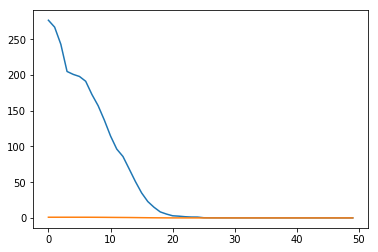

In [5]:
#Training

use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.backends.cudnn.deterministic = True

print("Training RNN")
print("------------")

attention = Attention(model_cfg["encoder"]["hidden_size"], model_cfg["decoder"]["hidden_size"], 64)
model = Seq2Seq(preproc.input_dim, preproc.vocab_size, attention, model_cfg)
model = model.cuda() if use_cuda else model.cpu()

optimizer = torch.optim.SGD(model.parameters(), lr=opt_cfg["learning_rate"], momentum=opt_cfg["momentum"])
#change this
mslst = [int(y) for y in [25 * x for x in range(1,20)] if y < opt_cfg["max_epochs"]]
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=mslst, gamma=0.1)

log="epoch {:4} | train_loss={:6.2f}, dev_loss={:6.2f} with {:6.2f}% WER ({:6.2f}s elapsed)"
losses = []
weres = []
eps = list(range(opt_cfg["max_epochs"]))

best_so_far = float("inf")
for ep in range(opt_cfg["max_epochs"]):
    start = time.time()
    scheduler.step()

    train_loss = train(model, optimizer, train_ldr)    
    dev_loss, dev_wer = evaluate(model, dev_ldr, preproc)    
    losses.append(dev_loss)
    weres.append(dev_wer)
    
    print(log.format(ep + 1, train_loss, dev_loss, dev_wer * 100., time.time() - start))
    for param_group in optimizer.param_groups:
        print('...learning rate: ' + str(param_group['lr']))

    torch.save(model, os.path.join(config["save_path"], str(ep)))   
    if dev_wer < best_so_far:
        best_so_far = dev_wer
        torch.save(model, os.path.join(config["save_path"], "best"))

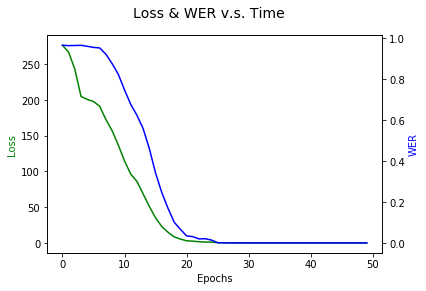

In [16]:
fig, ax1 = plt.subplots()
plt.suptitle("Loss & WER v.s. Time", fontsize=14)
ax2 = ax1.twinx()
ax1.plot(eps, losses, 'green')
ax2.plot(eps, weres, 'blue')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='green')
ax2.set_ylabel('WER', color='blue')

plt.show()

In [12]:
#Testing

print("Testing RNN")
print("-------------")

test_model = torch.load(os.path.join(config["save_path"], "best"))
_, test_wer = evaluate(test_model, test_ldr, preproc, store_prediction=True, print_prediction=True)

print("{:.2f}% WER (test)".format(test_wer * 100.))

Testing RNN
-------------


D:\TTIC-31110-Final-Project\rnn\model.py:181: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  x, h = self.enc_rnn(x)
D:\TTIC-31110-Final-Project\rnn\model.py:210: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  ox, hx = self.dec_rnn(ix, hx=hx)
D:\TTIC-31110-Final-Project\rnn\model.py:232: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  ox, hx = self.dec_rnn(ix, hx=hx)


True label:
  zhua1 zhu4 le5 zhuan3 ye4 zhuan2 gang3 pei2 xun4 jiu4 zhua1 zhu4 le5 shi4 chang3 jiu4 ye4 de5 zhong4 dian3 zhe4 yi3 yue4 lai2 yue4 cheng2 wei2 ren2 men5 de5 gong4 shi2 
Predicted labal:
  zhua1 zhu4 le5 zhuan3 ye4 zhuan2 gang3 pei2 xun4 jiu4 zhua1 zhu4 le5 shi4 chang3 jiu4 ye4 de5 zhong4 dian3 zhe4 yi3 yue4 lai2 yue4 cheng2 wei2 ren2 men5 de5 gong4 shi2 
True label:
  qi2 wu4 you2 mian2 er2 sha1 er2 bu4 qi2 shi4 you2 nong2 er2 gong1 er2 shang1 er2 jin1 rong2 qi2 di4 you2 hai3 jiang1 er2 zhong1 zhou1 xing2 jiang1 jin4 gui1 xi1 bei3 
Predicted labal:
  qi2 wu4 you2 mian2 er2 sha1 er2 bu4 qi2 shi4 you2 nong2 er2 gong1 er2 shang1 er2 jin1 rong2 qi2 di4 you2 hai3 jiang1 er2 zhong1 zhou1 xing2 jiang1 jin4 gui1 xi1 bei3 
True label:
  qi3 yin1 cha1 zuo4 yong4 de5 chu4 jiao3 he2 zhe5 pai1 jie2 er2 zhen4 dong4 xiang4 ting1 shen2 jing1 chuan2 di4 zui4 shi3 xiong2 wen2 gan3 xing4 qu5 de5 sheng1 yin1 xin4 xi1 
Predicted labal:
  qi3 yin1 cha1 zuo4 yong4 de5 chu4 jiao3 he2 zhe5 pai1 j

  ta1 men5 bu4 yin1 xun2 shou3 jiu4 bu4 wei2 wei3 nuo4 nuo4 gan3 yu2 fen4 dou4 ye3 gan3 yu2 li2 jie3 yao4 fen4 dou4 jiu4 hui4 you3 xi1 sheng1 de5 fen4 dou4 guan1 
Predicted labal:
  ta1 men5 bu4 yin1 xun2 shou3 jiu4 bu4 wei2 wei3 nuo4 nuo4 gan3 yu2 fen4 dou4 ye3 gan3 yu2 li2 jie3 yao4 fen4 dou4 jiu4 hui4 you3 xi1 sheng1 de5 fen4 dou4 guan1 
True label:
  jin4 lai2 yi1 xue2 jia1 you4 fa1 xian4 yin2 er3 duo1 tang2 you3 kang4 zhong3 liu2 de5 zuo4 yong4 zhe4 jiang1 wei4 yin2 er3 sheng1 chan3 kai1 chuang4 geng4 wei2 guang3 kuo4 de5 qian2 jing3 
Predicted labal:
  jin4 lai2 yi1 xue2 jia1 you4 fa1 xian4 yin2 er3 duo1 tang2 you3 kang4 zhong3 liu2 de5 zuo4 yong4 zhe4 jiang1 wei4 yin2 er3 sheng1 chan3 kai1 chuang4 geng4 wei2 guang3 kuo4 de5 qian2 jing3 
True label:
  tan2 dao4 di4 er4 jie1 duan4 tao2 tai4 sai4 wang2 da4 yong3 xi1 wang4 xian1 peng4 rui4 fa3 de2 deng3 ou1 zhou1 dui4 yin1 wei4 ta1 hen3 shu2 xi1 zhe4 xie1 dui4 
Predicted labal:
  tan2 dao4 di4 er4 jie1 duan4 tao2 tai4 sai4 wang2 da4

  dong1 bei3 jun1 de5 yi4 xie1 ai4 guo2 jiang4 shi4 ma3 zhan4 shan1 li3 du4 tang2 ju4 wu3 su1 bing3 ai4 deng4 tie3 mei2 deng3 ye3 fen4 qi3 kang4 zhan4 
Predicted labal:
  dong1 bei3 jun1 de5 yi4 xie1 ai4 guo2 jiang4 shi4 ma3 zhan4 shan1 li3 du4 tang2 ju4 wu3 su1 bing3 ai4 deng4 tie3 mei2 deng3 ye3 fen4 qi3 kang4 zhan4 
True label:
  wang2 ying1 han4 bei4 qiang1 bi4 hou4 bu4 fen5 yu2 nie4 shen1 cang2 qi3 lai5 ji3 ci4 wei2 bu3 jun1 wei4 zhua1 huo4 
Predicted labal:
  wang2 ying1 han4 bei4 qiang1 bi4 hou4 bu4 fen5 yu2 nie4 shen1 cang2 qi3 lai5 ji3 ci4 wei2 bu3 jun1 wei4 zhua1 huo4 
True label:
  ta1 men5 zou3 dao4 si4 ma3 lu4 yi4 jia1 cha2 shi2 pu4 li3 a1 jiu3 shuo1 yao4 xun1 yu2 ta1 gei3 mai3 le5 you4 gei3 zhuan3 er2 mai3 le5 bing3 gan1 
Predicted labal:
  ta1 men5 zou3 dao4 si4 ma3 lu4 yi4 jia1 cha2 shi2 pu4 li3 a1 jiu3 shuo1 yao4 xun1 yu2 ta1 gei3 mai3 le5 you4 gei3 zhuan3 er2 mai3 le5 bing3 gan1 
True label:
  ji3 tian1 lai2 ren2 men5 shuo1 jun1 sao3 zan4 jun1 sao3 xue2 jun1 sao3 ye3 

  shui4 wu4 ji1 guan1 an4 gui1 ding4 yi1 ju4 cun2 gen1 lian2 shou1 shui4 zi4 ran2 bei4 yao2 chang3 zuan1 le5 kong4 zi5 yao2 chang3 yi2 ci3 tou1 shui4 wu3 wan4 yuan2 
True label:
  ci3 jian1 pu3 bian4 ren4 wei2 gong1 jue2 bi3 da4 xuan3 geng4 zhong4 yao4 wei2 rao4 xian4 fa3 gong1 jue2 de5 zheng1 lun4 ye3 bi3 jing4 xuan3 ben3 shen1 geng4 jian1 rui4 fu4 za2 
Predicted labal:
  ci3 jian1 pu3 bian4 ren4 wei2 gong1 jue2 bi3 da4 xuan3 geng4 zhong4 yao4 wei2 rao4 xian4 fa3 gong1 jue2 de5 zheng1 lun4 ye3 bi3 jing4 xuan3 ben3 shen1 geng4 jian1 rui4 fu4 za2 
True label:
  dang1 ta1 yu3 guan1 bing1 chi1 wan2 chu2 xi1 ye4 de5 jiao3 zi5 jian3 cha2 wan2 you2 ku4 an1 quan2 cuo4 shi1 de5 luo4 shi2 you4 bu2 gu4 pi2 lao2 lian2 ye4 xia4 shan1 
Predicted labal:
  dang1 ta1 yu3 guan1 bing1 chi1 wan2 chu2 xi1 ye4 de5 jiao3 zi5 jian3 cha2 wan2 you2 ku4 an1 quan2 cuo4 shi1 de5 luo4 shi2 you4 bu2 gu4 pi2 lao2 lian2 ye4 xia4 shan1 
True label:
  fu4 yu5 le5 fen4 dou4 bu2 chuo4 guang3 kong1 hou4 jun1 xie4 chang3 y

  tan1 wu1 nuo2 yong4 juan1 zeng4 zhen4 zai1 kuan3 wu4 shi4 chu4 fan4 fa3 lv4 xing2 wei2 yao4 an4 zhao4 xing2 fa3 di4 yi4 bai3 er4 shi2 liu4 tiao2 gui1 ding4 yan2 su4 chu2 li3 
Predicted labal:
  tan1 wu1 nuo2 yong4 juan1 zeng4 zhen4 zai1 kuan3 wu4 shi4 chu4 fan4 fa3 lv4 xing2 wei2 yao4 an4 zhao4 xing2 fa3 di4 yi4 bai3 er4 shi2 liu4 tiao2 gui1 ding4 yan2 su4 chu2 li3 
True label:
  ci3 ci4 jiu4 yuan2 wu4 zi1 bao1 kuo4 yao4 pin3 yi1 liao2 qi4 xie4 ying2 yang2 pin3 wei4 sheng1 qing1 jie2 yong4 pin3 yi3 ji2 qi2 ta1 jiu4 zai1 wu4 pin3 deng3 
Predicted labal:
  ci3 ci4 jiu4 yuan2 wu4 zi1 bao1 kuo4 yao4 pin3 yi1 liao2 qi4 xie4 ying2 yang2 pin3 wei4 sheng1 qing1 jie2 yong4 pin3 yi3 ji2 qi2 ta1 jiu4 zai1 wu4 pin3 deng3 
True label:
  nong2 min2 quan1 di4 yang3 zhu1 wa1 tang2 yang3 yu2 kai1 shan1 zhong4 guo3 feng1 shan1 yu4 lin2 cong2 dan1 yi1 zhong4 yang3 xiang4 li4 ti3 yang3 zhi2 sheng1 tai4 nong2 ye4 mai4 jin4 
Predicted labal:
  nong2 min2 quan1 di4 yang3 zhu1 wa1 tang2 yang3 yu2 kai1 shan1

  zhao1 biao1 wen2 jian4 zhong1 suo3 lie4 gong1 cheng2 liang4 you3 wu4 cha1 shi2 ying1 dang1 yun2 xu3 zhong4 biao1 jia4 ge2 zuo4 xiang1 ying4 tiao2 zheng3 
Predicted labal:
  zhao1 biao1 wen2 jian4 zhong1 suo3 lie4 gong1 cheng2 liang4 you3 wu4 cha1 shi2 ying1 dang1 yun2 xu3 zhong4 biao1 jia4 ge2 zuo4 xiang1 ying4 tiao2 zheng3 
True label:
  ran2 er2 wo3 men5 ying1 gai1 you3 que4 hai2 mei2 you3 yi2 ge4 yan2 mi4 wan2 zheng3 de5 wai4 lai2 ren2 kou3 guan2 li3 tiao2 li4 he2 ji1 gou4 
Predicted labal:
  ran2 er2 wo3 men5 ying1 gai1 you3 que4 hai2 mei2 you3 yi2 ge4 yan2 mi4 wan2 zheng3 de5 wai4 lai2 ren2 kou3 guan2 li3 tiao2 li4 he2 ji1 gou4 
True label:
  wo3 dang1 shi2 you2 dian3 hun1 tou2 xiang3 jiu4 he2 ta1 fen1 shou3 suan4 le5 na3 pa4 deng1 ge4 bao4 zhi3 zheng1 hun1 ye3 xing2 wo3 lian2 gao3 zi5 dou1 zhun3 bei4 hao3 le5 
Predicted labal:
  wo3 dang1 shi2 you2 dian3 hun1 tou2 xiang3 jiu4 he2 ta1 fen1 shou3 suan4 le5 na3 pa4 deng1 ge4 bao4 zhi3 zheng1 hun1 ye3 xing2 wo3 lian2 gao3 zi5 dou1 

  san3 wen2 shi4 po1 ju4 mei4 li4 de5 yi1 zhong3 wen2 ti3 yin1 qi2 zai4 yu3 yan2 wen2 cai3 yu3 gou4 si1 he2 yi4 jing4 shang4 de5 jiang3 qiu2 san3 wen2 you4 you3 mei3 wen2 zhi1 cheng1 
True label:
  ru2 guo3 xia4 dao4 gu2 di3 dun4 jue2 han2 qi4 xi2 ren2 tai2 tou2 si4 gu4 yin1 sen1 sen1 de5 tu3 bi4 que4 you3 qun2 mo2 ya1 ding3 de5 jing1 xin1 dong4 po4 zhi1 gan3 
Predicted labal:
  ru2 guo3 xia4 dao4 gu2 di3 dun4 jue2 han2 qi4 xi2 ren2 tai2 tou2 si4 gu4 yin1 sen1 sen1 de5 tu3 bi4 que4 you3 qun2 mo2 ya1 ding3 de5 jing1 xin1 dong4 po4 zhi1 gan3 
True label:
  nv3 ren2 de5 sheng1 yin1 tu1 ran2 jia2 ran2 er2 zhi3 leng4 tou2 leng4 nao3 ting2 zai4 guan1 kong1 zhong1 hua4 chu1 yi2 dao4 hen2 fei1 zi3 ying2 tou2 zhuang4 shang4 
Predicted labal:
  nv3 ren2 de5 sheng1 yin1 tu1 ran2 jia2 ran2 er2 zhi3 leng4 tou2 leng4 nao3 ting2 zai4 guan1 kong1 zhong1 hua4 chu1 yi2 dao4 hen2 fei1 zi3 ying2 tou2 zhuang4 shang4 
True label:
  zao3 dao4 bo1 zhong4 he2 yu4 yang1 de5 tian1 qi4 tiao2 jian4 you3 li4 yu3 fo

  zhe4 wang2 zhen4 wang2 shou3 dao4 he4 bing3 yan2 liao4 han4 sheng1 wang2 en1 mao4 deng3 ba1 ren2 zu3 cheng2 jun1 zheng4 wei3 yuan2 hui4 yi3 wang2 shou3 dao4 wei2 shu1 ji5 
True label:
  yi3 jing1 kuai4 yi4 dian3 zhong1 le5 liu2 li4 hai2 mei2 hui2 jia1 shu1 yun2 kan4 zhe5 kong1 kong1 ru2 ye3 de5 jia1 xin1 li3 lve4 wei1 you2 dian3 chou2 chang4 
Predicted labal:
  yi3 jing1 kuai4 yi4 dian3 zhong1 le5 liu2 li4 hai2 mei2 hui2 jia1 shu1 yun2 kan4 zhe5 kong1 kong1 ru2 ye3 de5 jia1 xin1 li3 lve4 wei1 you2 dian3 chou2 chang4 
True label:
  han4 zheng4 jie1 yi1 gai3 wang3 ri4 fei4 fei4 yang2 yang2 de5 xuan1 nao4 qing2 jing3 jie1 liang3 pang2 de5 san1 qian1 duo1 ge4 tan1 peng2 jing4 jing4 de5 tang3 zai4 na4 li3 yang3 xi1 
Predicted labal:
  han4 zheng4 jie1 yi1 gai3 wang3 ri4 fei4 fei4 yang2 yang2 de5 xuan1 nao4 qing2 jing3 jie1 liang3 pang2 de5 san1 qian1 duo1 ge4 tan1 peng2 jing4 jing4 de5 tang3 zai4 na4 li3 yang3 xi1 
True label:
  chen2 mu4 hua2 lv3 zheng4 cao1 xia4 yan3 ying4 yao1 dan1 ren

  zhua1 zhu4 le5 zhuan3 ye4 zhuan2 gang3 pei2 xun4 jiu4 zhua1 zhu4 le5 shi4 chang3 jiu4 ye4 de5 zhong4 dian3 zhe4 yi3 yue4 lai2 yue4 cheng2 wei2 ren2 men5 de5 gong4 shi2 
True label:
  qi2 wu4 you2 mian2 er2 sha1 er2 bu4 qi2 shi4 you2 nong2 er2 gong1 er2 shang1 er2 jin1 rong2 qi2 di4 you2 hai3 jiang1 er2 zhong1 zhou1 xing2 jiang1 jin4 gui1 xi1 bei3 
Predicted labal:
  qi2 wu4 you2 mian2 er2 sha1 er2 bu4 qi2 shi4 you2 nong2 er2 gong1 er2 shang1 er2 jin1 rong2 qi2 di4 you2 hai3 jiang1 er2 zhong1 zhou1 xing2 jiang1 jin4 gui1 xi1 bei3 
True label:
  qi3 yin1 cha1 zuo4 yong4 de5 chu4 jiao3 he2 zhe5 pai1 jie2 er2 zhen4 dong4 xiang4 ting1 shen2 jing1 chuan2 di4 zui4 shi3 xiong2 wen2 gan3 xing4 qu5 de5 sheng1 yin1 xin4 xi1 
Predicted labal:
  qi3 yin1 cha1 zuo4 yong4 de5 chu4 jiao3 he2 zhe5 pai1 jie2 er2 zhen4 dong4 xiang4 ting1 shen2 jing1 chuan2 di4 zui4 shi3 xiong2 wen2 gan3 xing4 qu5 de5 sheng1 yin1 xin4 xi1 
True label:
  jia4 ri4 ou3 you3 peng2 you5 yue1 fang3 wo3 men5 ye3 duo1 shang1 di

  cheng2 yun4 ren2 you3 quan2 yao1 qiu2 tuo1 yun4 ren2 tian2 xie3 hang2 kong1 huo4 yun4 dan1 tuo1 yun4 ren2 you3 quan2 yao1 qiu2 cheng2 yun4 ren2 jie1 shou4 gai1 hang2 kong1 huo4 yun4 dan1 
True label:
  sui2 hou4 jiang1 zhu3 xi2 you2 a1 mo4 lin2 wai4 zhang3 pei2 tong2 cheng2 che1 qian2 wang3 shi4 nei4 na4 weng1 lv2 guan3 xia4 ta4 
Predicted labal:
  sui2 hou4 jiang1 zhu3 xi2 you2 a1 mo4 lin2 wai4 zhang3 pei2 tong2 cheng2 che1 qian2 wang3 shi4 nei4 na4 weng1 lv2 guan3 xia4 ta4 
True label:
  quan2 guo2 mei2 tan4 ding4 huo4 hui4 ji4 lv4 yan2 ming2 bu2 shou4 wai4 jie4 gan1 rao3 yin1 er2 ye3 cheng2 wei2 yi2 ge4 gao1 xiao4 lv5 de5 hui4 
Predicted labal:
  quan2 guo2 mei2 tan4 ding4 huo4 hui4 ji4 lv4 yan2 ming2 bu2 shou4 wai4 jie4 gan1 rao3 yin1 er2 ye3 cheng2 wei2 yi2 ge4 gao1 xiao4 lv5 de5 hui4 
True label:
  dang1 ran2 ta1 men5 bu2 xiang4 e4 yu2 na4 yang4 tun1 xia4 shi2 kuai4 dang4 zuo4 ya1 cang1 shi2 er2 shi4 mo2 cheng2 fen3 yi3 hou4 cai2 fu2 yong4 
Predicted labal:
  dang1 ran2 ta1 men

  guo2 wu4 yuan4 chu1 yu2 an1 quan2 kao3 lv4 mei2 you3 tou4 lu4 shui2 jiang1 qian2 wang3 ka1 bu4 er3 ye3 bu2 tou4 lu4 zhe4 wei4 wai4 jiao1 guan1 jiang1 cong2 he2 di4 chu1 fa1 
True label:
  yu2 shi4 ke4 tang2 shang4 pin1 ming4 yan3 suan4 shu4 xue2 ti2 er2 jiang1 yu3 wen2 zheng4 zhi4 deng3 diu1 dao4 yi4 bian1 zhong1 yu2 wei4 neng2 jin4 gao1 xiao4 da4 men2 
Predicted labal:
  yu2 shi4 ke4 tang2 shang4 pin1 ming4 yan3 suan4 shu4 xue2 ti2 er2 jiang1 yu3 wen2 zheng4 zhi4 deng3 diu1 dao4 yi4 bian1 zhong1 yu2 wei4 neng2 jin4 gao1 xiao4 da4 men2 
True label:
  zhe4 ci4 da4 gui1 mo2 wu3 zhuang1 chong1 tu1 shi4 you2 yu2 kun1 sha1 bu4 dui4 shang4 yue4 qiang3 zhan4 wa3 zu2 si4 bai3 ying1 mu3 ying1 su4 di4 er2 yin2 qi3 de5 
Predicted labal:
  zhe4 ci4 da4 gui1 mo2 wu3 zhuang1 chong1 tu1 shi4 you2 yu2 kun1 sha1 bu4 dui4 shang4 yue4 qiang3 zhan4 wa3 zu2 si4 bai3 ying1 mu3 ying1 su4 di4 er2 yin2 qi3 de5 
True label:
  er4 lou4 yong4 duo1 yong4 dan1 ci2 zhong1 de5 zi4 mu3 huo4 zhe3 jiang1 dan1 ci2 zhon

  yu2 mu4 zhai4 min2 su2 feng1 qing2 bie2 ju4 yi4 ge2 kai1 zhai4 men2 hun1 qu3 da3 san1 chao2 deng3 shi2 fen1 re4 nao5 ku1 jia4 tiao4 sang1 ji4 re4 nao5 you4 qi2 te4 
Predicted labal:
  yu2 mu4 zhai4 min2 su2 feng1 qing2 bie2 ju4 yi4 ge2 kai1 zhai4 men2 hun1 qu3 da3 san1 chao2 deng3 shi2 fen1 re4 nao5 ku1 jia4 tiao4 sang1 ji4 re4 nao5 you4 qi2 te4 
True label:
  jiu3 yue4 yi2 ri4 yong4 tie2 guan3 da3 si3 la1 na4 wa2 li4 mu2 zi3 de5 yi4 ming2 zhun3 wei4 zai4 su4 she4 bei4 ren2 qiang1 sha1 mie4 kou3 
Predicted labal:
  jiu3 yue4 yi2 ri4 yong4 tie2 guan3 da3 si3 la1 na4 wa2 li4 mu2 zi3 de5 yi4 ming2 zhun3 wei4 zai4 su4 she4 bei4 ren2 qiang1 sha1 mie4 kou3 
True label:
  wo3 de2 de5 yue4 shao3 dui4 lian2 meng2 yue4 you3 hao3 chu4 yin1 wei4 ta1 men5 ren4 wei2 wo3 huo4 xu3 hui4 gei3 xin1 jin4 qiu2 yuan2 kai1 xia4 e4 li4 
Predicted labal:
  wo3 de2 de5 yue4 shao3 dui4 lian2 meng2 yue4 you3 hao3 chu4 yin1 wei4 ta1 men5 ren4 wei2 wo3 huo4 xu3 hui4 gei3 xin1 jin4 qiu2 yuan2 kai1 xia4 e4 li4 
Tru

  xi1 zhou1 wang2 zui4 hou4 yi2 ge4 wang2 shi4 zhou1 you1 wang2 ta1 chong3 ai4 fei1 zi5 bao1 si4 fei4 diao4 shen1 hou4 yin2 qi3 shen1 hou4 fu4 qin5 shen1 hou2 de5 bu4 man3 
True label:
  ri4 ben3 bu4 jin3 fou3 ren4 qin1 lve4 zhan4 zheng1 er2 qie3 hai2 jin4 er2 xuan1 yang2 qin1 lve4 you2 li3 lun4 qin1 lve4 you3 gong1 lun4 
Predicted labal:
  ri4 ben3 bu4 jin3 fou3 ren4 qin1 lve4 zhan4 zheng1 er2 qie3 hai2 jin4 er2 xuan1 yang2 qin1 lve4 you2 li3 lun4 qin1 lve4 you3 gong1 lun4 
True label:
  yin1 er2 ta1 de5 yan3 zou4 zhi4 pu3 er2 sa3 tuo1 yin1 se4 ji2 yun4 lv4 ru2 xing2 yun2 liu2 shui3 ban1 shu1 chang4 er2 chun2 mei3 
Predicted labal:
  yin1 er2 ta1 de5 yan3 zou4 zhi4 pu3 er2 sa3 tuo1 yin1 se4 ji2 yun4 lv4 ru2 xing2 yun2 liu2 shui3 ban1 shu1 chang4 er2 chun2 mei3 
True label:
  yi1 yuan4 tai4 ping2 jian1 lao3 gong1 ren2 wu2 yong3 yuan2 huan4 xiao4 chuan3 bing4 ke2 sou5 ting3 li4 hai5 fei1 dei3 dong4 shou3 gei3 yan4 le5 qi4 de5 li3 run4 wu3 huan4 yi1 fu5 
Predicted labal:
  yi1 yuan4 tai4

  yi2 dao4 sheng4 xia4 xing1 wei4 shen4 nong2 yu2 er2 bao4 zao4 shi1 sheng1 yuan3 qu4 ou2 you3 lai2 zhe3 ye3 shi4 zai4 chun1 fen1 shi2 jie2 qiu1 yu3 zhi1 hou4 
True label:
  zai4 nv2 zi3 yi1 bai2 mi3 zi4 you2 yong3 jue2 sai4 zhong1 wo3 guo2 yong3 tan2 nv3 jie2 yue4 jing4 yi2 yi3 wu3 shi2 si4 miao3 wu3 shi2 de5 cheng2 ji4 zhe2 gui4 
Predicted labal:
  zai4 nv2 zi3 yi1 bai2 mi3 zi4 you2 yong3 jue2 sai4 zhong1 wo3 guo2 yong3 tan2 nv3 jie2 yue4 jing4 yi2 yi3 wu3 shi2 si4 miao3 wu3 shi2 de5 cheng2 ji4 zhe2 gui4 
True label:
  tai4 ping2 nian2 yue4 qian1 jin1 zhi1 zeng4 bu2 suan4 kang1 kai3 kun4 nan2 shi2 hou5 yi1 fan4 zhi1 yao1 jiu4 ling4 ren2 gan3 dao4 wen1 nuan3 ru2 chun1 le5 
Predicted labal:
  tai4 ping2 nian2 yue4 qian1 jin1 zhi1 zeng4 bu2 suan4 kang1 kai3 kun4 nan2 shi2 hou5 yi1 fan4 zhi1 yao1 jiu4 ling4 ren2 gan3 dao4 wen1 nuan3 ru2 chun1 le5 
True label:
  zui4 hou4 sen1 guai4 song4 gou3 di4 xiao3 du1 ta1 ze2 kai1 che1 ba3 ji1 tou2 sang1 ni2 zai4 hui2 sang1 ni2 wei4 zai4 nan2 gang3 

  ting1 lao3 wai4 qin2 yuan2 shuo1 you3 de5 nv3 ren2 ri4 zi5 leng3 qing1 jin1 bu2 zhu4 yu4 huo3 ru2 fen2 chang2 zai4 an4 zhong1 yu3 nan2 wai4 qin2 yuan2 xun2 huan1 zuo4 le4 
Predicted labal:
  ting1 lao3 wai4 qin2 yuan2 shuo1 you3 de5 nv3 ren2 ri4 zi5 leng3 qing1 jin1 bu2 zhu4 yu4 huo3 ru2 fen2 chang2 zai4 an4 zhong1 yu3 nan2 wai4 qin2 yuan2 xun2 huan1 zuo4 le4 
True label:
  hong2 zhuan1 hui1 wa3 lv4 shu4 yan3 ying4 cun1 zhou1 wei2 shi4 yang2 guang1 xia4 yi2 wang4 wu2 ji4 de5 tian2 ye3 he2 guo3 yuan2 hao3 yi2 pai4 tian2 yuan2 feng1 guang1 
Predicted labal:
  hong2 zhuan1 hui1 wa3 lv4 shu4 yan3 ying4 cun1 zhou1 wei2 shi4 yang2 guang1 xia4 yi2 wang4 wu2 ji4 de5 tian2 ye3 he2 guo3 yuan2 hao3 yi2 pai4 tian2 yuan2 feng1 guang1 
True label:
  wo3 pi1 zhe5 wo3 cu1 cao1 yuan2 shi3 da4 hong2 da4 lv4 de5 yang2 mao2 pi1 jian1 ca1 qu4 le5 kou3 hong2 wai1 zai4 kao4 bei4 yi3 li3 yi4 zhi1 jie1 yi4 zhi1 chou1 yan1 
Predicted labal:
  wo3 pi1 zhe5 wo3 cu1 cao1 yuan2 shi3 da4 hong2 da4 lv4 de5 yang2 ma

  zai4 shi4 chang3 jing4 zheng1 zhong1 qi3 ye4 zai4 zhan4 lve4 shang4 ying1 yi3 shi4 chang3 wei2 zhong1 xin1 zai4 yun4 ying2 shang4 ying1 yi3 cai2 wu4 wei2 zhong1 xin1 dan4 yi2 qie4 gong1 zuo4 dou1 yao4 kao4 ren2 qu4 zuo4 
Predicted labal:
  zai4 shi4 chang3 jing4 zheng1 zhong1 qi3 ye4 zai4 zhan4 lve4 shang4 ying1 yi3 shi4 chang3 wei2 zhong1 xin1 zai4 yun4 ying2 shang4 ying1 yi3 cai2 wu4 wei2 zhong1 xin1 dan4 yi2 qie4 gong1 zuo4 dou1 yao4 kao4 ren2 qu4 zuo4 
True label:
  yu2 ci3 tong2 shi2 ou1 mei3 ao4 deng3 guo2 zhong4 duo1 hua2 qiao2 ying4 zheng1 ru4 wu3 kai1 fu4 ou1 ya4 ge4 zhan4 chang3 tong2 de2 yi4 ri4 fa3 xi1 si1 yu4 xue4 fen4 zhan4 
Predicted labal:
  yu2 ci3 tong2 shi2 ou1 mei3 ao4 deng3 guo2 zhong4 duo1 hua2 qiao2 ying4 zheng1 ru4 wu3 kai1 fu4 ou1 ya4 ge4 zhan4 chang3 tong2 de2 yi4 ri4 fa3 xi1 si1 yu4 xue4 fen4 zhan4 
True label:
  wo3 yan2 jiu1 guo4 nin2 nin2 de5 chang2 shou4 de2 li4 yu2 nin2 te4 bie2 jian4 kang1 de5 ren2 ge2 wen2 xue2 xiu1 yang3 he2 huo4 da2 you1 mo4 
Predi

  xiang1 chuan2 jin4 chao2 song1 jiang1 ren2 zhang1 han4 zai4 luo4 yang2 zuo4 guan1 yin1 xiang3 nian4 jia1 xiang1 juan4 wu4 gu1 cai4 chun2 geng1 lu2 yu2 kuai4 er2 gao4 lao3 huan2 xiang1 
True label:
  qi2 zhong4 zhi2 de5 hong2 fu4 shi4 ping2 guo3 yi3 se4 ze2 yan4 li4 guo3 zhi4 xi4 cui4 zhi1 duo1 wei4 mei3 he2 ji2 nai4 zhu4 yun4 er2 xiang3 yu4 hai3 nei4 wai4 
Predicted labal:
  qi2 zhong4 zhi2 de5 hong2 fu4 shi4 ping2 guo3 yi3 se4 ze2 yan4 li4 guo3 zhi4 xi4 cui4 zhi1 duo1 wei4 mei3 he2 ji2 nai4 zhu4 yun4 er2 xiang3 yu4 hai3 nei4 wai4 
True label:
  shan1 ding3 you3 she3 shen1 ya2 zhong1 wu3 yi3 hou4 wang2 wang3 ke2 yi3 jian4 dao4 shui3 zheng1 qi4 zhe2 she4 er2 cheng2 de5 wu3 se4 guang1 huan2 cheng1 wei2 fo2 guang1 
Predicted labal:
  shan1 ding3 you3 she3 shen1 ya2 zhong1 wu3 yi3 hou4 wang2 wang3 ke2 yi3 jian4 dao4 shui3 zheng1 qi4 zhe2 she4 er2 cheng2 de5 wu3 se4 guang1 huan2 cheng1 wei2 fo2 guang1 
True label:
  e2 fang1 jian1 chi2 sai1 wa3 si1 tuo1 bo1 er3 ji1 di4 you2 e2 jian4 dui4 

  feng1 lei2 jiao1 jia1 de5 yan2 han2 li3 wo3 jun1 ying1 yong3 pin1 sha1 you3 si4 ge4 ying2 gong1 ru4 bao1 tou2 cheng2 nei4 tong2 di2 jun1 zhan3 kai1 bai2 ren4 xiang4 zhan4 
True label:
  jie2 zhi4 jin1 nian2 wu3 yue4 quan2 qu1 liang2 mian2 you2 shou1 gou4 qi3 ye4 gong4 nuo2 yong4 hui2 long2 zi1 jin1 san1 qian1 si4 bai2 wu3 shi2 wan4 yuan2 yong4 yu2 fu4 ying2 ye4 wu4 
Predicted labal:
  jie2 zhi4 jin1 nian2 wu3 yue4 quan2 qu1 liang2 mian2 you2 shou1 gou4 qi3 ye4 gong4 nuo2 yong4 hui2 long2 zi1 jin1 san1 qian1 si4 bai2 wu3 shi2 wan4 yuan2 yong4 yu2 fu4 ying2 ye4 wu4 
True label:
  di4 er4 yao4 ba3 jing1 ji4 shou3 duan4 he2 qia4 dang4 de5 xing2 zheng4 shou3 duan4 jie2 he2 qi3 lai2 jia1 yi3 yun4 yong4 te4 bie2 yao4 zhu4 yi4 yun4 yong4 hao3 jing1 ji4 shou3 duan4 
Predicted labal:
  di4 er4 yao4 ba3 jing1 ji4 shou3 duan4 he2 qia4 dang4 de5 xing2 zheng4 shou3 duan4 jie2 he2 qi3 lai2 jia1 yi3 yun4 yong4 te4 bie2 yao4 zhu4 yi4 yun4 yong4 hao3 jing1 ji4 shou3 duan4 
True label:
  mao2 zhen4 yua

  ru2 jin1 ta1 ming2 chuan2 si4 fang1 sheng1 bo1 si4 hai3 yang3 xie1 ji4 shu4 guang3 wei2 liu2 chuan2 you1 liang2 xie1 zhong3 yuan2 yuan2 bu2 duan4 shu1 song4 dao4 qian1 jia1 wan4 hu4 
Predicted labal:
  ru2 jin1 ta1 ming2 chuan2 si4 fang1 sheng1 bo1 si4 hai3 yang3 xie1 ji4 shu4 guang3 wei2 liu2 chuan2 you1 liang2 xie1 zhong3 yuan2 yuan2 bu2 duan4 shu1 song4 dao4 qian1 jia1 wan4 hu4 
True label:
  ta1 yuan2 qi3 yu2 wo3 guo2 zhong3 liu2 leng3 dong4 wai4 ke1 zhuan1 jia1 qi2 qian2 jun1 chuang4 zao4 fa1 ming2 de5 e4 xing4 zhong3 liu2 ti3 wai4 leng3 dong4 fa3 yu3 leng3 dong4 kang4 ai2 yi4 miao2 
Predicted labal:
  ta1 yuan2 qi3 yu2 wo3 guo2 zhong3 liu2 leng3 dong4 wai4 ke1 zhuan1 jia1 qi2 qian2 jun1 chuang4 zao4 fa1 ming2 de5 e4 xing4 zhong3 liu2 ti3 wai4 leng3 dong4 fa3 yu3 leng3 dong4 kang4 ai2 yi4 miao2 
True label:
  bao3 ding4 shi4 yan2 mian2 chang3 dian4 lan3 dian4 xian4 chang3 he2 mu4 heng2 dan1 chang3 de5 jiao1 he2 ban3 fen1 chang3 yuan2 shi4 lian2 nian2 kui1 sun3 de5 ting2 chan3 ba

  ya4 zhou1 shi4 ya4 xi4 ya4 zhou1 de5 jian3 cheng1 wei4 yu2 dong1 ban4 qiu2 de5 dong1 bei3 bu4 dong1 lin2 tai4 ping2 yang2 nan2 jie1 yin4 du4 yang2 bei3 bin1 bei3 bing1 yang2 
Predicted labal:
  ya4 zhou1 shi4 ya4 xi4 ya4 zhou1 de5 jian3 cheng1 wei4 yu2 dong1 ban4 qiu2 de5 dong1 bei3 bu4 dong1 lin2 tai4 ping2 yang2 nan2 jie1 yin4 du4 yang2 bei3 bin1 bei3 bing1 yang2 
True label:
  jian4 zhu4 ye4 shi4 dong1 yang2 de5 chuan2 tong3 you1 shi4 lu2 zhai2 su4 yong1 tang2 shi4 ming2 dai4 min2 zhai2 de5 dian3 fan4 xian4 wei2 guo2 jia1 zhong4 dian3 wen2 wu4 bao3 hu4 dan1 wei4 
Predicted labal:
  jian4 zhu4 ye4 shi4 dong1 yang2 de5 chuan2 tong3 you1 shi4 lu2 zhai2 su4 yong1 tang2 shi4 ming2 dai4 min2 zhai2 de5 dian3 fan4 xian4 wei2 guo2 jia1 zhong4 dian3 wen2 wu4 bao3 hu4 dan1 wei4 
True label:
  guo2 wu4 yuan4 chu1 yu2 an1 quan2 kao3 lv4 mei2 you3 tou4 lu4 shui2 jiang1 qian2 wang3 ka1 bu4 er3 ye3 bu2 tou4 lu4 zhe4 wei4 wai4 jiao1 guan1 jiang1 cong2 he2 di4 chu1 fa1 
Predicted labal:
  guo2 wu4 

  zheng4 en1 bo1 de5 liu2 shao4 tang2 zhuan4 yong4 nong2 mo4 zhong4 cai3 huo2 sheng1 sheng1 de5 ke4 hua4 chu1 liu2 shao4 tang2 de5 wei2 wen2 he2 wei2 ren2 
True label:
  qi2 zhong1 xiong1 ya2 li4 wei2 san1 shi2 wu3 yi4 mei3 yuan2 jie2 ke4 wei2 er4 shi2 wu3 yi4 mei3 yuan2 bo1 lan2 wei2 er4 shi2 wu3 yi4 mei3 yuan2 e2 luo2 si1 da2 er4 shi2 yi4 mei3 yuan2 
Predicted labal:
  qi2 zhong1 xiong1 ya2 li4 wei2 san1 shi2 wu3 yi4 mei3 yuan2 jie2 ke4 wei2 er4 shi2 wu3 yi4 mei3 yuan2 bo1 lan2 wei2 er4 shi2 wu3 yi4 mei3 yuan2 e2 luo2 si1 da2 er4 shi2 yi4 mei3 yuan2 
True label:
  tai2 wan1 ying1 you4 er2 ying2 yang3 zhuan1 jia1 hai2 yu3 xia4 men2 shi4 tong2 hang2 jiu4 ying1 you4 er2 de5 sheng1 zhang3 fa1 yu4 jin4 xing2 zhuan1 ti2 tan4 tao3 
Predicted labal:
  tai2 wan1 ying1 you4 er2 ying2 yang3 zhuan1 jia1 hai2 yu3 xia4 men2 shi4 tong2 hang2 jiu4 ying1 you4 er2 de5 sheng1 zhang3 fa1 yu4 jin4 xing2 zhuan1 ti2 tan4 tao3 
True label:
  xiang4 zhang1 wang2 cun1 ba1 shi2 nian2 dai4 si4 bai3 hu4 yong1 yo

  jing1 cha2 ming2 mo4 yong3 ji4 gong4 fei1 fa3 yin4 shua1 tu2 shu1 yi4 bai2 wu3 shi2 si4 zhong3 jin4 er4 bai3 ling2 si4 wan4 ce4 fei1 fa3 jing1 ying2 e2 da2 er4 bai3 er4 shi5 ba1 wan4 duo1 yuan2 
True label:
  tong2 she3 sheng1 jie1 pi1 qi3 xiu4 dai4 zhu1 ying1 bao3 shi4 zhi1 mao4 yao1 bai2 yu4 zhi1 huan2 zuo3 pei4 dao1 you4 bei4 rong2 chou4 ye4 ran2 ruo4 shen2 ren2 
Predicted labal:
  tong2 she3 sheng1 jie1 pi1 qi3 xiu4 dai4 zhu1 ying1 bao3 shi4 zhi1 mao4 yao1 bai2 yu4 zhi1 huan2 zuo3 pei4 dao1 you4 bei4 rong2 chou4 ye4 ran2 ruo4 shen2 ren2 
True label:
  jia1 zhu4 jiao1 dong1 kuang4 jia1 shu3 yuan4 de5 shen1 lao2 hu3 you2 yu2 suo3 zai4 qi3 ye4 xiao4 yi4 bu4 jia1 jia1 shang5 chang2 nian2 huan4 bing4 yi1 liao2 fei4 yi3 hua1 qu4 er4 wan4 duo1 yuan2 sheng1 huo2 ji2 du4 kun4 nan2 
Predicted labal:
  jia1 zhu4 jiao1 dong1 kuang4 jia1 shu3 yuan4 de5 shen1 lao2 hu3 you2 yu2 suo3 zai4 qi3 ye4 xiao4 yi4 bu4 jia1 jia1 shang5 chang2 nian2 huan4 bing4 yi1 liao2 fei4 yi3 hua1 qu4 er4 wan4 duo1 yu

  yu2 mu4 zhai4 min2 su2 feng1 qing2 bie2 ju4 yi4 ge2 kai1 zhai4 men2 hun1 qu3 da3 san1 chao2 deng3 shi2 fen1 re4 nao5 ku1 jia4 tiao4 sang1 ji4 re4 nao5 you4 qi2 te4 
Predicted labal:
  yu2 mu4 zhai4 min2 su2 feng1 qing2 bie2 ju4 yi4 ge2 kai1 zhai4 men2 hun1 qu3 da3 san1 chao2 deng3 shi2 fen1 re4 nao5 ku1 jia4 tiao4 sang1 ji4 re4 nao5 you4 qi2 te4 
True label:
  jiu3 yue4 yi2 ri4 yong4 tie2 guan3 da3 si3 la1 na4 wa2 li4 mu2 zi3 de5 yi4 ming2 zhun3 wei4 zai4 su4 she4 bei4 ren2 qiang1 sha1 mie4 kou3 
Predicted labal:
  jiu3 yue4 yi2 ri4 yong4 tie2 guan3 da3 si3 la1 na4 wa2 li4 mu2 zi3 de5 yi4 ming2 zhun3 wei4 zai4 su4 she4 bei4 ren2 qiang1 sha1 mie4 kou3 
True label:
  wo3 de2 de5 yue4 shao3 dui4 lian2 meng2 yue4 you3 hao3 chu4 yin1 wei4 ta1 men5 ren4 wei2 wo3 huo4 xu3 hui4 gei3 xin1 jin4 qiu2 yuan2 kai1 xia4 e4 li4 
Predicted labal:
  wo3 de2 de5 yue4 shao3 dui4 lian2 meng2 yue4 you3 hao3 chu4 yin1 wei4 ta1 men5 ren4 wei2 wo3 huo4 xu3 hui4 gei3 xin1 jin4 qiu2 yuan2 kai1 xia4 e4 li4 
Tru

  fa1 she4 yue1 er4 shi2 fen1 zhong1 hou4 fei1 xing2 yang4 ji1 da3 kai1 jiang4 luo4 san3 jian4 luo4 zai4 bei2 wei3 er4 shi2 ba1 du4 wu3 shi2 yi1 fen1 dong1 jing1 yi4 bai3 si4 shi2 san1 du4 si4 shi2 fen1 de5 tai4 ping2 yang2 hai3 mian4 shang5 
True label:
  shan1 dong1 sheng3 yan1 tai2 ao4 er3 hu1 si1 yao4 ye4 you3 xian4 gong1 si1 jin4 ri4 yan2 zhi4 cheng2 gong1 wai4 yong4 jiang4 xue4 ya1 xin1 yao4 li4 ya1 ping2 shuang1 
Predicted labal:
  shan1 dong1 sheng3 yan1 tai2 ao4 er3 hu1 si1 yao4 ye4 you3 xian4 gong1 si1 jin4 ri4 yan2 zhi4 cheng2 gong1 wai4 yong4 jiang4 xue4 ya1 xin1 yao4 li4 ya1 ping2 shuang1 
True label:
  ling4 wai4 wai4 mao4 wu4 zi1 yun4 shu1 liang4 jiang1 you3 jiao4 da4 de5 zeng1 zhang3 ye3 lian4 wu4 zi1 he2 xi1 bu4 yuan2 you2 yun4 shu1 liang4 ye2 you3 yi2 ding4 zeng1 zhang3 
Predicted labal:
  ling4 wai4 wai4 mao4 wu4 zi1 yun4 shu1 liang4 jiang1 you3 jiao4 da4 de5 zeng1 zhang3 ye3 lian4 wu4 zi1 he2 xi1 bu4 yuan2 you2 yun4 shu1 liang4 ye2 you3 yi2 ding4 zeng1 zhang3 
True 

  peng2 you5 men5 kan4 wo3 tiao4 wu3 ru4 le5 mi2 xi4 cheng1 wo3 lao3 wan2 nao4 lao3 ban4 jian4 wo3 tiao4 wu3 shang4 le5 yin3 ma4 wo3 shen2 jing1 bing4 
True label:
  you2 yu2 jian3 ce4 zao3 yun4 yin1 zi3 ke2 yi3 que4 zhen3 chao1 zao3 yun4 xu1 zuo4 ren2 gong1 liu2 chan3 de5 yun4 fu4 ke3 mian3 shou4 shou3 shu4 zhi1 ku3 
Predicted labal:
  you2 yu2 jian3 ce4 zao3 yun4 yin1 zi3 ke2 yi3 que4 zhen3 chao1 zao3 yun4 xu1 zuo4 ren2 gong1 liu2 chan3 de5 yun4 fu4 ke3 mian3 shou4 shou3 shu4 zhi1 ku3 
True label:
  xia4 yu3 shi2 jie2 da4 jia1 dou1 huang1 mang2 shang4 shan1 qu5 wa1 sun3 you4 dao4 gou1 li3 zhuo1 tian2 ji1 wu2 nai4 mei2 you3 you2 chang2 chang2 chi1 de5 wei4 suan1 
Predicted labal:
  xia4 yu3 shi2 jie2 da4 jia1 dou1 huang1 mang2 shang4 shan1 qu5 wa1 sun3 you4 dao4 gou1 li3 zhuo1 tian2 ji1 wu2 nai4 mei2 you3 you2 chang2 chang2 chi1 de5 wei4 suan1 
True label:
  zhan3 wang4 yi1 jiu3 jiu3 liu4 nian2 quan2 heng2 ao4 men2 nei4 wai4 zhu1 duo1 you3 li4 yin1 su4 yu3 bu2 li4 yin1 su4 you3 li4 yi

  zhi4 yu2 ling3 nan2 wen2 hua4 de5 xing2 cheng2 ze2 shi4 nan2 yue4 tu3 zhu4 wen2 hua4 tong2 zhong1 yuan2 wen2 hua4 zhou1 bian1 wen2 hua4 ji2 hai3 yang2 wen2 hua4 rong2 he2 de5 jie2 guo3 
Predicted labal:
  zhi4 yu2 ling3 nan2 wen2 hua4 de5 xing2 cheng2 ze2 shi4 nan2 yue4 tu3 zhu4 wen2 hua4 tong2 zhong1 yuan2 wen2 hua4 zhou1 bian1 wen2 hua4 ji2 hai3 yang2 wen2 hua4 rong2 he2 de5 jie2 guo3 
True label:
  hai2 you3 de5 zhong1 jian1 jia1 za2 shi2 ying2 xiang4 duan4 er2 bu2 luan4 zhi1 bing1 wen2 qi2 xuan2 zhuan4 quan1 si1 fan2 ji3 shi2 zhong4 er2 ci4 di4 bu2 luan4 
Predicted labal:
  hai2 you3 de5 zhong1 jian1 jia1 za2 shi2 ying2 xiang4 duan4 er2 bu2 luan4 zhi1 bing1 wen2 qi2 xuan2 zhuan4 quan1 si1 fan2 ji3 shi2 zhong4 er2 ci4 di4 bu2 luan4 
True label:
  ci3 wai4 sha1 yu2 yu2 long2 he2 hai3 tun2 jin4 guan3 wai4 mao4 shang4 hen3 xiang1 si4 dou1 shan4 chang2 you2 yong3 you3 ren2 ba3 ta1 men5 gui1 shu3 yu2 lei4 
Predicted labal:
  ci3 wai4 sha1 yu2 yu2 long2 he2 hai3 tun2 jin4 guan3 wai4 mao

  qi2 lin2 shi2 zhi1 shi2 yu3 yun2 wu4 zhi1 xu1 xiang1 ying4 cheng2 qi4 shi5 gei3 ren2 yi3 xiong2 yang2 zhi1 gan3 xiong1 jin1 wei2 zhi1 er2 kuo4 qing2 huai2 wei2 zhi1 ji1 dang4 
Predicted labal:
  qi2 lin2 shi2 zhi1 shi2 yu3 yun2 wu4 zhi1 xu1 xiang1 ying4 cheng2 qi4 shi5 gei3 ren2 yi3 xiong2 yang2 zhi1 gan3 xiong1 jin1 wei2 zhi1 er2 kuo4 qing2 huai2 wei2 zhi1 ji1 dang4 
True label:
  zhi4 yu2 ling3 nan2 wen2 hua4 de5 xing2 cheng2 ze2 shi4 nan2 yue4 tu3 zhu4 wen2 hua4 tong2 zhong1 yuan2 wen2 hua4 zhou1 bian1 wen2 hua4 ji2 hai3 yang2 wen2 hua4 rong2 he2 de5 jie2 guo3 
Predicted labal:
  zhi4 yu2 ling3 nan2 wen2 hua4 de5 xing2 cheng2 ze2 shi4 nan2 yue4 tu3 zhu4 wen2 hua4 tong2 zhong1 yuan2 wen2 hua4 zhou1 bian1 wen2 hua4 ji2 hai3 yang2 wen2 hua4 rong2 he2 de5 jie2 guo3 
True label:
  hai2 you3 de5 zhong1 jian1 jia1 za2 shi2 ying2 xiang4 duan4 er2 bu2 luan4 zhi1 bing1 wen2 qi2 xuan2 zhuan4 quan1 si1 fan2 ji3 shi2 zhong4 er2 ci4 di4 bu2 luan4 
Predicted labal:
  hai2 you3 de5 zhong1 jian1 j

  jia1 zhu4 jiao1 dong1 kuang4 jia1 shu3 yuan4 de5 shen1 lao2 hu3 you2 yu2 suo3 zai4 qi3 ye4 xiao4 yi4 bu4 jia1 jia1 shang5 chang2 nian2 huan4 bing4 yi1 liao2 fei4 yi3 hua1 qu4 er4 wan4 duo1 yuan2 sheng1 huo2 ji2 du4 kun4 nan2 
True label:
  you2 yu2 yu3 zhou4 kong1 jian1 huan2 jing4 xian3 e4 yin1 ci3 fan3 hui2 cang1 dou1 zuo4 cheng2 mi4 feng1 shi4 shi3 cheng2 yuan2 yu3 yu3 zhou4 kong1 jian1 huan2 jing4 wan2 quan2 ge2 jue2 
Predicted labal:
  you2 yu2 yu3 zhou4 kong1 jian1 huan2 jing4 xian3 e4 yin1 ci3 fan3 hui2 cang1 dou1 zuo4 cheng2 mi4 feng1 shi4 shi3 cheng2 yuan2 yu3 yu3 zhou4 kong1 jian1 huan2 jing4 wan2 quan2 ge2 jue2 
True label:
  wo3 zhi3 shi4 yao4 nin2 zhi1 dao4 wo3 ai4 nin2 ru2 guo3 you3 xia4 bei4 zi5 wo3 reng2 yuan4 yi4 zuo4 nin2 er2 zi5 
Predicted labal:
  wo3 zhi3 shi4 yao4 nin2 zhi1 dao4 wo3 ai4 nin2 ru2 guo3 you3 xia4 bei4 zi5 wo3 reng2 yuan4 yi4 zuo4 nin2 er2 zi5 
True label:
  wei4 le5 shi3 sheng1 yu4 an4 ji4 hua4 jin4 xing2 jiu4 yao4 yun4 yong4 yi1 xue2 ke1 xue2 de5 

  hai2 kou3 shi4 gong1 an1 ju2 xing2 zhen1 chu4 wu3 yue4 shi2 er4 ri4 jiang1 ding3 feng1 qiang3 jie2 zuo4 an4 de5 liu4 ming2 dai3 tu2 yi4 wang2 da3 jin4 bing4 dang1 chang3 jiao3 huo4 yi4 pi1 zang1 kuan3 zang1 wu4 
True label:
  zhao1 biao1 wen2 jian4 zhong1 suo3 lie4 gong1 cheng2 liang4 you3 wu4 cha1 shi2 ying1 dang1 yun2 xu3 zhong4 biao1 jia4 ge2 zuo4 xiang1 ying4 tiao2 zheng3 
Predicted labal:
  zhao1 biao1 wen2 jian4 zhong1 suo3 lie4 gong1 cheng2 liang4 you3 wu4 cha1 shi2 ying1 dang1 yun2 xu3 zhong4 biao1 jia4 ge2 zuo4 xiang1 ying4 tiao2 zheng3 
True label:
  ran2 er2 wo3 men5 ying1 gai1 you3 que4 hai2 mei2 you3 yi2 ge4 yan2 mi4 wan2 zheng3 de5 wai4 lai2 ren2 kou3 guan2 li3 tiao2 li4 he2 ji1 gou4 
Predicted labal:
  ran2 er2 wo3 men5 ying1 gai1 you3 que4 hai2 mei2 you3 yi2 ge4 yan2 mi4 wan2 zheng3 de5 wai4 lai2 ren2 kou3 guan2 li3 tiao2 li4 he2 ji1 gou4 
True label:
  wo3 dang1 shi2 you2 dian3 hun1 tou2 xiang3 jiu4 he2 ta1 fen1 shou3 suan4 le5 na3 pa4 deng1 ge4 bao4 zhi3 zheng1 hun1

  peng2 you5 men5 kan4 wo3 tiao4 wu3 ru4 le5 mi2 xi4 cheng1 wo3 lao3 wan2 nao4 lao3 ban4 jian4 wo3 tiao4 wu3 shang4 le5 yin3 ma4 wo3 shen2 jing1 bing4 
Predicted labal:
  peng2 you5 men5 kan4 wo3 tiao4 wu3 ru4 le5 mi2 xi4 cheng1 wo3 lao3 wan2 nao4 lao3 ban4 jian4 wo3 tiao4 wu3 shang4 le5 yin3 ma4 wo3 shen2 jing1 bing4 
True label:
  you2 yu2 jian3 ce4 zao3 yun4 yin1 zi3 ke2 yi3 que4 zhen3 chao1 zao3 yun4 xu1 zuo4 ren2 gong1 liu2 chan3 de5 yun4 fu4 ke3 mian3 shou4 shou3 shu4 zhi1 ku3 
Predicted labal:
  you2 yu2 jian3 ce4 zao3 yun4 yin1 zi3 ke2 yi3 que4 zhen3 chao1 zao3 yun4 xu1 zuo4 ren2 gong1 liu2 chan3 de5 yun4 fu4 ke3 mian3 shou4 shou3 shu4 zhi1 ku3 
True label:
  xia4 yu3 shi2 jie2 da4 jia1 dou1 huang1 mang2 shang4 shan1 qu5 wa1 sun3 you4 dao4 gou1 li3 zhuo1 tian2 ji1 wu2 nai4 mei2 you3 you2 chang2 chang2 chi1 de5 wei4 suan1 
Predicted labal:
  xia4 yu3 shi2 jie2 da4 jia1 dou1 huang1 mang2 shang4 shan1 qu5 wa1 sun3 you4 dao4 gou1 li3 zhuo1 tian2 ji1 wu2 nai4 mei2 you3 you2 chang2 c

  ta1 de5 wai4 xing2 te4 zheng1 shi4 tou2 zhong1 deng3 da4 bi2 liang2 duo1 wei1 long2 yan3 da4 ming2 liang4 er3 jiao4 duan3 hou4 jing3 xi4 qian2 xiong1 kuan1 guang3 ti2 xiao3 er2 zhi4 jian1 
True label:
  guo2 wu4 wei3 yuan2 jian1 guo2 wu4 yuan4 mi4 shu1 zhang3 luo2 gan4 min2 zheng4 bu4 bu4 zhang3 duo1 ji2 cai2 rang4 ye3 yi4 tong2 qian2 wang3 yan2 an1 kan4 wang4 ren2 min2 qun2 zhong4 
Predicted labal:
  guo2 wu4 wei3 yuan2 jian1 guo2 wu4 yuan4 mi4 shu1 zhang3 luo2 gan4 min2 zheng4 bu4 bu4 zhang3 duo1 ji2 cai2 rang4 ye3 yi4 tong2 qian2 wang3 yan2 an1 kan4 wang4 ren2 min2 qun2 zhong4 
True label:
  dong1 bei3 jun1 de5 yi4 xie1 ai4 guo2 jiang4 shi4 ma3 zhan4 shan1 li3 du4 tang2 ju4 wu3 su1 bing3 ai4 deng4 tie3 mei2 deng3 ye3 fen4 qi3 kang4 zhan4 
Predicted labal:
  dong1 bei3 jun1 de5 yi4 xie1 ai4 guo2 jiang4 shi4 ma3 zhan4 shan1 li3 du4 tang2 ju4 wu3 su1 bing3 ai4 deng4 tie3 mei2 deng3 ye3 fen4 qi3 kang4 zhan4 
True label:
  wang2 ying1 han4 bei4 qiang1 bi4 hou4 bu4 fen5 yu2 nie4 shen1 c

  bei3 jing1 feng1 tai2 qu1 nong2 min2 zi4 ji3 hua1 qian2 chou2 ban4 wan4 fo2 yan2 shou4 si4 ying2 chun1 miao4 hui4 xi1 yin3 le5 qu1 nei4 liu4 shi2 zhi1 yang1 ge5 dui4 can1 sai4 
Predicted labal:
  bei3 jing1 feng1 tai2 qu1 nong2 min2 zi4 ji3 hua1 qian2 chou2 ban4 wan4 fo2 yan2 shou4 si4 ying2 chun1 miao4 hui4 xi1 yin3 le5 qu1 nei4 liu4 shi2 zhi1 yang1 ge5 dui4 can1 sai4 
True label:
  zai4 shi4 chang3 jing4 zheng1 zhong1 qi3 ye4 zai4 zhan4 lve4 shang4 ying1 yi3 shi4 chang3 wei2 zhong1 xin1 zai4 yun4 ying2 shang4 ying1 yi3 cai2 wu4 wei2 zhong1 xin1 dan4 yi2 qie4 gong1 zuo4 dou1 yao4 kao4 ren2 qu4 zuo4 
Predicted labal:
  zai4 shi4 chang3 jing4 zheng1 zhong1 qi3 ye4 zai4 zhan4 lve4 shang4 ying1 yi3 shi4 chang3 wei2 zhong1 xin1 zai4 yun4 ying2 shang4 ying1 yi3 cai2 wu4 wei2 zhong1 xin1 dan4 yi2 qie4 gong1 zuo4 dou1 yao4 kao4 ren2 qu4 zuo4 
True label:
  yu2 ci3 tong2 shi2 ou1 mei3 ao4 deng3 guo2 zhong4 duo1 hua2 qiao2 ying4 zheng1 ru4 wu3 kai1 fu4 ou1 ya4 ge4 zhan4 chang3 tong2 de2 yi4 r

  zhi4 yu2 ling3 nan2 wen2 hua4 de5 xing2 cheng2 ze2 shi4 nan2 yue4 tu3 zhu4 wen2 hua4 tong2 zhong1 yuan2 wen2 hua4 zhou1 bian1 wen2 hua4 ji2 hai3 yang2 wen2 hua4 rong2 he2 de5 jie2 guo3 
True label:
  hai2 you3 de5 zhong1 jian1 jia1 za2 shi2 ying2 xiang4 duan4 er2 bu2 luan4 zhi1 bing1 wen2 qi2 xuan2 zhuan4 quan1 si1 fan2 ji3 shi2 zhong4 er2 ci4 di4 bu2 luan4 
Predicted labal:
  hai2 you3 de5 zhong1 jian1 jia1 za2 shi2 ying2 xiang4 duan4 er2 bu2 luan4 zhi1 bing1 wen2 qi2 xuan2 zhuan4 quan1 si1 fan2 ji3 shi2 zhong4 er2 ci4 di4 bu2 luan4 
True label:
  ci3 wai4 sha1 yu2 yu2 long2 he2 hai3 tun2 jin4 guan3 wai4 mao4 shang4 hen3 xiang1 si4 dou1 shan4 chang2 you2 yong3 you3 ren2 ba3 ta1 men5 gui1 shu3 yu2 lei4 
Predicted labal:
  ci3 wai4 sha1 yu2 yu2 long2 he2 hai3 tun2 jin4 guan3 wai4 mao4 shang4 hen3 xiang1 si4 dou1 shan4 chang2 you2 yong3 you3 ren2 ba3 ta1 men5 gui1 shu3 yu2 lei4 
True label:
  li4 yong4 gun3 zhuang1 chuan2 ke2 yi3 yong4 ka3 che1 huo4 qian1 yin3 che1 ba3 huo4 wu4 cong2 g

  wo3 yan2 jiu1 guo4 nin2 nin2 de5 chang2 shou4 de2 li4 yu2 nin2 te4 bie2 jian4 kang1 de5 ren2 ge2 wen2 xue2 xiu1 yang3 he2 huo4 da2 you1 mo4 
True label:
  fei1 ji1 chuan1 guo4 yun2 ceng2 yan3 xia4 yi2 pian4 yun2 hai3 you3 shi2 tou4 guo4 xi1 bo2 de5 yun2 wu4 yi1 xi1 ke3 jian4 nan2 guo2 cong1 lv4 de5 qun2 shan1 da4 di4 
Predicted labal:
  fei1 ji1 chuan1 guo4 yun2 ceng2 yan3 xia4 yi2 pian4 yun2 hai3 you3 shi2 tou4 guo4 xi1 bo2 de5 yun2 wu4 yi1 xi1 ke3 jian4 nan2 guo2 cong1 lv4 de5 qun2 shan1 da4 di4 
True label:
  zhou1 gu3 cheng2 fei4 xiao4 tong1 wang2 zhao4 hua2 kuang1 ya4 ming2 zang1 ke4 jia1 luo2 zhu2 feng1 wu2 fu4 heng2 deng3 ming2 ren2 xue2 zhe3 wei2 ben3 shu1 gu4 wen4 
Predicted labal:
  zhou1 gu3 cheng2 fei4 xiao4 tong1 wang2 zhao4 hua2 kuang1 ya4 ming2 zang1 ke4 jia1 luo2 zhu2 feng1 wu2 fu4 heng2 deng3 ming2 ren2 xue2 zhe3 wei2 ben3 shu1 gu4 wen4 
True label:
  zhe4 shi4 you2 bei3 jing1 lin2 ye4 da4 xue2 wang2 bin1 rui4 jiao4 shou4 dai4 ling3 de5 zhuan1 ti2 zu3 yong4 ba1 nian2

  yi1 jiu3 wu3 ling2 nian2 ba1 yue4 zhong1 yang1 ren2 min2 zheng4 fu3 zheng4 wu4 yuan4 ban1 bu4 le5 bao3 zhang4 fa1 ming2 quan2 yu3 zhuan1 li4 quan2 zan4 xing2 tiao2 li4 
Predicted labal:
  yi1 jiu3 wu3 ling2 nian2 ba1 yue4 zhong1 yang1 ren2 min2 zheng4 fu3 zheng4 wu4 yuan4 ban1 bu4 le5 bao3 zhang4 fa1 ming2 quan2 yu3 zhuan1 li4 quan2 zan4 xing2 tiao2 li4 
True label:
  ling4 wai4 zai4 yong4 cao3 suan1 xi3 mo4 shui3 ji4 hou4 yao4 duo1 yong4 qing1 shui2 xi3 ji3 bian4 bu2 rang4 duo1 yu2 de5 cao3 suan1 liu2 zai4 yi1 fu5 shang4 
Predicted labal:
  ling4 wai4 zai4 yong4 cao3 suan1 xi3 mo4 shui3 ji4 hou4 yao4 duo1 yong4 qing1 shui2 xi3 ji3 bian4 bu2 rang4 duo1 yu2 de5 cao3 suan1 liu2 zai4 yi1 fu5 shang4 
True label:
  na4 zhi1 yang2 shao4 ye5 cong2 chao2 xian3 dai4 hui2 lai5 de5 mao2 bi3 rang4 xiao2 jie3 gei3 reng1 jin4 zi4 zhi2 lou3 li3 wo3 niang2 yi4 shi2 mei2 cha2 jue2 gei3 diu1 le5 
Predicted labal:
  na4 zhi1 yang2 shao4 ye5 cong2 chao2 xian3 dai4 hui2 lai5 de5 mao2 bi3 rang4 xiao2 jie3

  yi4 qun2 ru2 huo3 qiu2 de5 wa2 wa5 bian4 gun3 dong4 jin4 chang3 mei3 ren2 chi2 liang3 duo3 da4 huang2 hua1 fei1 wu3 si4 feng1 chui1 hua1 pu3 jing4 li4 ruo4 ju2 yuan2 tu3 xiang1 
True label:
  jiu4 zai4 na4 yin1 gou1 pang2 bian1 que4 gao1 gao1 xia4 xia4 fang4 zhe5 ji3 pen2 hua1 ye2 you3 jia1 zhu2 tao2 ye2 you3 chang2 qing1 de5 pen2 zai1 
Predicted labal:
  jiu4 zai4 na4 yin1 gou1 pang2 bian1 que4 gao1 gao1 xia4 xia4 fang4 zhe5 ji3 pen2 hua1 ye2 you3 jia1 zhu2 tao2 ye2 you3 chang2 qing1 de5 pen2 zai1 
True label:
  xi1 ri4 de5 gao1 mu3 cun1 qi1 bai3 kou3 ren2 jin3 guang1 gun4 han4 jiu4 you3 er4 bai3 duo1 zhuang1 hu4 ren2 qiong2 de2 lian2 ge4 cheng1 yan2 da3 you2 de5 qian2 ye3 mei2 you3 
Predicted labal:
  xi1 ri4 de5 gao1 mu3 cun1 qi1 bai3 kou3 ren2 jin3 guang1 gun4 han4 jiu4 you3 er4 bai3 duo1 zhuang1 hu4 ren2 qiong2 de2 lian2 ge4 cheng1 yan2 da3 you2 de5 qian2 ye3 mei2 you3 
True label:
  fa1 she4 yue1 er4 shi2 fen1 zhong1 hou4 fei1 xing2 yang4 ji1 da3 kai1 jiang4 luo4 san3 jian4 luo

  zheng4 yin1 wei4 ci3 si1 nuo4 ceng2 gan3 chu4 po1 shen1 de5 shuo1 lu3 xun4 sui1 shen1 cai2 shou4 ruo4 ai2 xiao3 dan4 he2 lu3 xun4 zai4 yi4 qi3 ni3 bi4 xu1 yang3 shi4 zhe5 qu4 ling3 hui4 na4 chong2 gao1 de5 si1 xiang3 
True label:
  han2 dian4 wei4 yu2 xi1 bei3 dian4 wang3 mo4 duan1 qi2 an1 quan2 sheng1 chan3 dui4 gai1 dian4 wang3 wen3 ding4 yun4 xing2 you3 zhong4 yao4 yi4 yi5 
Predicted labal:
  han2 dian4 wei4 yu2 xi1 bei3 dian4 wang3 mo4 duan1 qi2 an1 quan2 sheng1 chan3 dui4 gai1 dian4 wang3 wen3 ding4 yun4 xing2 you3 zhong4 yao4 yi4 yi5 
True label:
  zhe4 zhong3 ban4 fa3 wang2 wang3 shi3 chuang4 li4 yue4 duo1 de5 yin2 hang2 liu2 cheng2 bi3 li4 xiang1 dui4 yue4 xiao3 kui1 sun3 yue4 duo1 de5 yin2 hang2 liu2 cheng2 bi3 li4 xiang1 dui4 yue4 da4 
Predicted labal:
  zhe4 zhong3 ban4 fa3 wang2 wang3 shi3 chuang4 li4 yue4 duo1 de5 yin2 hang2 liu2 cheng2 bi3 li4 xiang1 dui4 yue4 xiao3 kui1 sun3 yue4 duo1 de5 yin2 hang2 liu2 cheng2 bi3 li4 xiang1 dui4 yue4 da4 
True label:
  ci3 wai4 yu3 q

  you2 tai4 yuan2 shi4 nan2 jiao1 qu1 kou4 zhuang1 cun1 nong2 min2 tou2 zi1 shu4 bai3 wan4 yuan2 jian4 she4 de5 ping2 yang2 ji2 mao4 shi4 chang3 yin1 guan2 li3 deng3 zhu1 fang1 mian4 de5 yuan2 yin1 yi3 ting2 ye4 yi4 nian2 
Predicted labal:
  you2 tai4 yuan2 shi4 nan2 jiao1 qu1 kou4 zhuang1 cun1 nong2 min2 tou2 zi1 shu4 bai3 wan4 yuan2 jian4 she4 de5 ping2 yang2 ji2 mao4 shi4 chang3 yin1 guan2 li3 deng3 zhu1 fang1 mian4 de5 yuan2 yin1 yi3 ting2 ye4 yi4 nian2 
True label:
  ji2 long2 po1 jiao1 wai4 yi2 zuo4 shi2 er4 ceng2 gong1 yu4 shi2 yi1 ri4 xia4 wu3 tu1 ran2 dao3 ta1 jiang1 wu3 shi2 duo1 ming2 fang2 ke4 kun4 zai4 li3 mian4 
Predicted labal:
  ji2 long2 po1 jiao1 wai4 yi2 zuo4 shi2 er4 ceng2 gong1 yu4 shi2 yi1 ri4 xia4 wu3 tu1 ran2 dao3 ta1 jiang1 wu3 shi2 duo1 ming2 fang2 ke4 kun4 zai4 li3 mian4 
True label:
  xuan3 yi4 ben3 hao3 shu1 shi3 ni3 li2 xiao3 yang4 er2 dun4 yu4 chu4 ni4 jing4 er2 bu4 nei3 chang1 ru2 xia4 hua1 chun1 cao3 sheng4 ruo4 jin3 duan4 lie4 huo3 
Predicted labal:
  

  zui4 hou4 sen1 guai4 song4 gou3 di4 xiao3 du1 ta1 ze2 kai1 che1 ba3 ji1 tou2 sang1 ni2 zai4 hui2 sang1 ni2 wei4 zai4 nan2 gang3 che1 zhan4 fu4 jin4 de5 pian1 pi4 su4 she4 
Predicted labal:
  zui4 hou4 sen1 guai4 song4 gou3 di4 xiao3 du1 ta1 ze2 kai1 che1 ba3 ji1 tou2 sang1 ni2 zai4 hui2 sang1 ni2 wei4 zai4 nan2 gang3 che1 zhan4 fu4 jin4 de5 pian1 pi4 su4 she4 
True label:
  ya4 zhou1 shi4 ya4 xi4 ya4 zhou1 de5 jian3 cheng1 wei4 yu2 dong1 ban4 qiu2 de5 dong1 bei3 bu4 dong1 lin2 tai4 ping2 yang2 nan2 jie1 yin4 du4 yang2 bei3 bin1 bei3 bing1 yang2 
Predicted labal:
  ya4 zhou1 shi4 ya4 xi4 ya4 zhou1 de5 jian3 cheng1 wei4 yu2 dong1 ban4 qiu2 de5 dong1 bei3 bu4 dong1 lin2 tai4 ping2 yang2 nan2 jie1 yin4 du4 yang2 bei3 bin1 bei3 bing1 yang2 
True label:
  jian4 zhu4 ye4 shi4 dong1 yang2 de5 chuan2 tong3 you1 shi4 lu2 zhai2 su4 yong1 tang2 shi4 ming2 dai4 min2 zhai2 de5 dian3 fan4 xian4 wei2 guo2 jia1 zhong4 dian3 wen2 wu4 bao3 hu4 dan1 wei4 
Predicted labal:
  jian4 zhu4 ye4 shi4 dong1 yan

  zhua1 zhu4 le5 zhuan3 ye4 zhuan2 gang3 pei2 xun4 jiu4 zhua1 zhu4 le5 shi4 chang3 jiu4 ye4 de5 zhong4 dian3 zhe4 yi3 yue4 lai2 yue4 cheng2 wei2 ren2 men5 de5 gong4 shi2 
Predicted labal:
  zhua1 zhu4 le5 zhuan3 ye4 zhuan2 gang3 pei2 xun4 jiu4 zhua1 zhu4 le5 shi4 chang3 jiu4 ye4 de5 zhong4 dian3 zhe4 yi3 yue4 lai2 yue4 cheng2 wei2 ren2 men5 de5 gong4 shi2 
True label:
  qi2 wu4 you2 mian2 er2 sha1 er2 bu4 qi2 shi4 you2 nong2 er2 gong1 er2 shang1 er2 jin1 rong2 qi2 di4 you2 hai3 jiang1 er2 zhong1 zhou1 xing2 jiang1 jin4 gui1 xi1 bei3 
Predicted labal:
  qi2 wu4 you2 mian2 er2 sha1 er2 bu4 qi2 shi4 you2 nong2 er2 gong1 er2 shang1 er2 jin1 rong2 qi2 di4 you2 hai3 jiang1 er2 zhong1 zhou1 xing2 jiang1 jin4 gui1 xi1 bei3 
True label:
  qi3 yin1 cha1 zuo4 yong4 de5 chu4 jiao3 he2 zhe5 pai1 jie2 er2 zhen4 dong4 xiang4 ting1 shen2 jing1 chuan2 di4 zui4 shi3 xiong2 wen2 gan3 xing4 qu5 de5 sheng1 yin1 xin4 xi1 
Predicted labal:
  qi3 cha2 cha1 zuo4 yong4 de5 chu4 jiao3 he2 zhe5 pai1 jie2 er2 zhen

  er2 ling4 yi1 wei4 yin1 ai4 zi1 bing4 sang4 ming4 de5 jue2 shi4 yue4 da4 shi1 ye3 ke2 yi3 yin1 zui4 jia1 chun2 yin1 yue4 yan3 zou4 jiang3 er2 han2 xiao4 jiu3 quan2 le5 
True label:
  jing1 ying2 ren2 yuan2 wei4 jing1 lv3 xing2 she4 tong2 yi4 bu4 de2 pi1 lu4 shi3 yong4 huo4 zhe3 yun2 xu3 ta1 ren2 shi3 yong4 qi2 suo3 zhang3 wo4 de5 lv3 xing2 she4 shang1 ye4 mi4 mi4 
Predicted labal:
  jing1 ying2 ren2 yuan2 wei4 jing1 lv3 xing2 she4 tong2 yi4 bu4 de2 pi1 lu4 shi3 yong4 huo4 zhe3 yun2 xu3 ta1 ren2 shi3 yong4 qi2 suo3 zhang3 wo4 de5 lv3 xing2 she4 shang1 ye4 mi4 mi4 
True label:
  ruo4 neng2 yun4 guang3 chang2 she2 jiang1 zhong4 ren2 nao3 jin1 zhong1 ai4 guo2 ji1 guan1 bo1 dong4 ze2 sui1 ya1 zhi4 bu4 xu3 qi2 ai4 guo2 kong3 bu4 ke3 de2 
Predicted labal:
  ruo4 neng2 yun4 guang3 chang2 she2 jiang1 zhong4 ren2 nao3 jin1 zhong1 ai4 guo2 ji1 guan1 bo1 dong4 ze2 sui1 ya1 zhi4 bu4 xu3 qi2 ai4 guo2 kong3 bu4 ke3 de2 
True label:
  zhe4 zhong3 ban4 fa3 wang2 wang3 shi3 chuang4 li4 yue4 duo1 de5 y

  qi3 yin1 cha1 zuo4 yong4 de5 chu4 jiao3 he2 zhe5 pai1 jie2 er2 zhen4 dong4 xiang4 ting1 shen2 jing1 chuan2 di4 zui4 shi3 xiong2 wen2 gan3 xing4 qu5 de5 sheng1 yin1 xin4 xi1 
True label:
  jia4 ri4 ou3 you3 peng2 you5 yue1 fang3 wo3 men5 ye3 duo1 shang1 ding4 yu2 mou3 cha2 guan3 jian4 yue1 ji4 sheng3 jia1 ren2 ying4 chou5 you4 de2 shu1 xin1 huan2 jing4 
Predicted labal:
  jia4 ri4 ou3 you3 peng2 you5 yue1 fang3 wo3 men5 ye3 duo1 shang1 ding4 yu2 mou3 cha2 guan3 jian4 yue1 ji4 sheng3 jia1 ren2 ying4 chou5 you4 de2 shu1 xin1 huan2 jing4 
True label:
  tong2 shi2 ye3 jie3 jue2 le5 ren2 gong1 pao1 yang1 jun1 yun2 du4 cha4 de5 wen4 ti2 pao1 yang1 ji1 pao1 chu1 de5 yang1 miao2 luo4 tian2 jun1 yun2 you3 li4 yu2 fang2 bing4 shi3 pao1 yang1 ji4 shu4 chong1 fen4 fa1 hui1 zuo4 yong4 
Predicted labal:
  tong2 shi2 ye3 jie3 jue2 le5 ren2 gong1 pao1 yang1 jun1 yun2 du4 cha4 de5 wen4 ti2 pao1 yang1 ji1 pao1 chu1 de5 yang1 miao2 luo4 tian2 jun1 yun2 you3 li4 yu2 fang2 bing4 shi3 pao1 yang1 ji4 shu4 c

  da4 gai4 dai4 zhi4 ming2 qing1 zhi1 ji4 yue4 bing5 cai2 yue4 zhi4 yue4 jing1 chi1 yue4 bing5 zhi1 feng1 ye3 jiu4 zhu2 jian4 sheng4 xing2 qi3 lai5 
Predicted labal:
  da4 gai4 dai4 zhi4 ming2 qing1 zhi1 ji4 yue4 bing5 cai2 yue4 zhi4 yue4 jing1 chi1 yue4 bing5 zhi1 feng1 ye3 jiu4 zhu2 jian4 sheng4 xing2 qi3 lai5 
True label:
  qi3 ye4 fa1 xing2 qi3 ye4 zhai4 quan4 suo3 chou2 zi1 jin1 ying1 dang1 an4 zhao4 shen3 pi1 ji1 guan1 pi1 zhun3 de5 yong4 tu2 yong4 yu2 ben3 qi3 ye4 de5 sheng1 chan3 jing1 ying2 
Predicted labal:
  qi3 ye4 fa1 xing2 qi3 ye4 zhai4 quan4 suo3 chou2 zi1 jin1 ying1 dang1 an4 zhao4 shen3 pi1 ji1 guan1 pi1 zhun3 de5 yong4 tu2 yong4 yu2 ben3 qi3 ye4 de5 sheng1 chan3 jing1 ying2 
True label:
  ta1 ce4 ce4 tou2 you4 cong2 zuo3 bian1 chui1 kan4 ta1 jie2 mao2 hao3 xiang4 qiang2 tou2 cao3 yi2 yang4 zuo3 you4 yao2 bai3 sui2 ta1 wan2 nong4 zhen1 hao3 wan2 
Predicted labal:
  ta1 ce4 ce4 tou2 you4 cong2 zuo3 bian1 chui1 kan4 ta1 jie2 mao2 hao3 xiang4 qiang2 tou2 cao3 yi2 yang4 zu

  ta1 ren4 wei2 wu2 lun4 shi4 nao3 xue4 shuan1 hai2 shi4 nao3 yi4 xue4 jun1 wei2 lu2 nei4 xue4 ye4 xun2 huan2 zhang4 ai4 nao3 zu3 zhi1 shou4 sun3 suo3 zhi4 
Predicted labal:
  ta1 ren4 wei2 wu2 lun4 shi4 nao3 xue4 shuan1 hai2 shi4 nao3 yi4 xue4 jun1 wei2 lu2 nei4 xue4 ye4 xun2 huan2 zhang4 ai4 nao3 zu3 zhi1 shou4 sun3 suo3 zhi4 
True label:
  fei1 zhou1 pu2 yu3 guo2 jia1 bao1 kuo4 an1 ge1 la1 mo4 sang1 bi3 ke4 ji3 nei4 ya4 bi3 shao4 fo2 de2 jiao3 sheng4 duo1 mei3 he2 pu3 lin2 xi1 bi3 wu3 guo2 
Predicted labal:
  fei1 zhou1 pu2 yu3 guo2 jia1 bao1 kuo4 an1 ge1 la1 mo4 sang1 bi3 ke4 ji3 nei4 ya4 bi3 shao4 fo2 de2 jiao3 sheng4 duo1 mei3 he2 pu3 lin2 xi1 bi3 wu3 guo2 
True label:
  ta1 de5 wai4 xing2 te4 zheng1 shi4 tou2 zhong1 deng3 da4 bi2 liang2 duo1 wei1 long2 yan3 da4 ming2 liang4 er3 jiao4 duan3 hou4 jing3 xi4 qian2 xiong1 kuan1 guang3 ti2 xiao3 er2 zhi4 jian1 
Predicted labal:
  ta1 de5 wai4 xing2 te4 zheng1 shi4 tou2 zhong1 deng3 da4 bi2 liang2 duo1 wei1 long2 yan3 da4 ming2 liang4 

  dang1 ta1 yu3 guan1 bing1 chi1 wan2 chu2 xi1 ye4 de5 jiao3 zi5 jian3 cha2 wan2 you2 ku4 an1 quan2 cuo4 shi1 de5 luo4 shi2 you4 bu2 gu4 pi2 lao2 lian2 ye4 xia4 shan1 
True label:
  fu4 yu5 le5 fen4 dou4 bu2 chuo4 guang3 kong1 hou4 jun1 xie4 chang3 yong4 chuang4 ye4 jing1 shen5 jian4 chang3 yu4 ren2 
Predicted labal:
  fu4 yu5 le5 fen4 dou4 bu2 chuo4 guang3 kong1 hou4 jun1 xie4 chang3 yong4 chuang4 ye4 jing1 shen5 jian4 chang3 yu4 ren2 
True label:
  yin1 ci3 long2 tong3 de5 shuo1 nv3 ren2 zen3 yang4 zen3 yang4 bi3 shuo1 nan2 ren5 zen3 yang4 zen3 yang4 yao4 you2 ba3 wo4 xie1 
Predicted labal:
  yin1 ci3 long2 tong3 de5 shuo1 nv3 ren2 zen3 yang4 zen3 yang4 bi3 shuo1 nan2 ren5 zen3 yang4 zen3 yang4 yao4 you2 ba3 wo4 xie1 
True label:
  da4 gai4 dai4 zhi4 ming2 qing1 zhi1 ji4 yue4 bing5 cai2 yue4 zhi4 yue4 jing1 chi1 yue4 bing5 zhi1 feng1 ye3 jiu4 zhu2 jian4 sheng4 xing2 qi3 lai5 
Predicted labal:
  da4 gai4 dai4 zhi4 ming2 qing1 zhi1 ji4 yue4 bing5 cai2 yue4 zhi4 yue4 jing1 chi1 yue4 bin

  nong2 ye4 yin2 hang2 jiang1 bei3 qu1 zhi1 hang2 zheng4 quan4 ye4 wu4 bu4 ye4 wu4 yuan2 xu2 yue4 lin2 yi3 dai4 mou2 si1 shou4 hui4 san1 shi2 yi2 wan4 yuan2 
True label:
  tong2 shi2 fen3 zhuang4 si4 liao4 ye3 yi3 bei4 ke1 li4 zhuang4 suo3 ti4 dai4 er2 wo3 guo2 nong2 cun1 reng2 zai4 shi3 yong4 ying2 yang3 jia4 zhi2 jiao4 di1 de5 hun4 he2 si4 liao4 
Predicted labal:
  tong2 shi2 fen3 zhuang4 si4 liao4 ye3 yi3 bei4 ke1 li4 zhuang4 suo3 ti4 dai4 er2 wo3 guo2 nong2 cun1 reng2 zai4 shi3 yong4 ying2 yang3 jia4 zhi2 jiao4 di1 de5 hun4 he2 si4 liao4 
True label:
  duan3 tu2 ke4 che1 he2 bu4 fen5 wo4 pu4 bu4 man3 yuan2 ye3 bu4 deng3 yu2 tie3 lu4 yun4 li4 bu2 zai4 jin3 zhang1 tie3 lu4 jian4 she4 bu4 fa2 si1 hao2 bu4 ke3 fang4 man4 
Predicted labal:
  duan3 tu2 ke4 che1 he2 bu4 fen5 wo4 pu4 bu4 man3 yuan2 ye3 bu4 deng3 yu2 tie3 lu4 yun4 li4 bu2 zai4 jin3 zhang1 tie3 lu4 jian4 she4 bu4 fa2 si1 hao2 bu4 ke3 fang4 man4 
True label:
  yun4 yong4 zhe4 zhong3 yi2 qi4 xin1 hua2 yi1 yuan4 you4 qiang3 jiu

  jin4 lai2 yi1 xue2 jia1 you4 fa1 xian4 yin2 er3 duo1 tang2 you3 kang4 zhong3 liu2 de5 zuo4 yong4 zhe4 jiang1 wei4 yin2 er3 sheng1 chan3 kai1 chuang4 geng4 wei2 guang3 kuo4 de5 qian2 jing3 
True label:
  tan2 dao4 di4 er4 jie1 duan4 tao2 tai4 sai4 wang2 da4 yong3 xi1 wang4 xian1 peng4 rui4 fa3 de2 deng3 ou1 zhou1 dui4 yin1 wei4 ta1 hen3 shu2 xi1 zhe4 xie1 dui4 
Predicted labal:
  tan2 dao4 di4 er4 jie1 duan4 tao2 tai4 sai4 wang2 da4 yong3 xi1 wang4 xian1 peng4 rui4 fa3 de2 deng3 ou1 zhou1 dui4 yin1 wei4 ta1 hen3 shu2 xi1 zhe4 xie1 dui4 
True label:
  long2 dong1 zai4 shan1 xi1 yun4 cheng2 di4 qu1 zun1 cun1 yin3 huang2 guan4 qu1 de5 tian2 ye3 shang4 yi2 pai4 re4 qi4 teng2 teng2 de5 fan2 mang2 jing3 xiang4 
Predicted labal:
  long2 dong1 zai4 shan1 xi1 yun4 cheng2 di4 qu1 zun1 cun1 yin3 huang2 guan4 qu1 de5 tian2 ye3 shang4 yi2 pai4 re4 qi4 teng2 teng2 de5 fan2 mang2 jing3 xiang4 
True label:
  feng1 lei2 jiao1 jia1 de5 yan2 han2 li3 wo3 jun1 ying1 yong3 pin1 sha1 you3 si4 ge4 ying2 gon

  ai4 sen1 hao2 wei1 er3 tu2 shu1 guan3 she4 zai4 kan1 sa4 si1 zhou1 guan2 li3 bu4 shao3 zhan2 pin3 shi4 wai4 guo2 ling2 dao3 ren2 zeng4 song4 gei3 ai4 sen1 hao2 wei1 er3 de5 li2 pin3 
True label:
  wu3 yue4 de5 yi4 tian1 xia4 da4 yu3 yang2 tai2 shang4 lou4 jin4 xu3 duo1 yu2 shui3 ke3 you4 mei2 you3 pai2 shui3 dong4 zhi2 hao3 yi4 pen2 pen2 wang3 wai4 duan1 
Predicted labal:
  wu3 yue4 de5 yi4 tian1 xia4 da4 yu3 yang2 tai2 shang4 lou4 jin4 xu3 duo1 yu2 shui3 ke3 you4 mei2 you3 pai2 shui3 dong4 zhi2 hao3 yi4 pen2 pen2 wang3 wai4 duan1 
True label:
  yi1 jiu3 wu3 ling2 nian2 ba1 yue4 zhong1 yang1 ren2 min2 zheng4 fu3 zheng4 wu4 yuan4 ban1 bu4 le5 bao3 zhang4 fa1 ming2 quan2 yu3 zhuan1 li4 quan2 zan4 xing2 tiao2 li4 
Predicted labal:
  yi1 jiu3 wu3 ling2 nian2 ba1 yue4 zhong1 yang1 ren2 min2 zheng4 fu3 zheng4 wu4 yuan4 ban1 bu4 le5 bao3 zhang4 fa1 ming2 quan2 yu3 zhuan1 li4 quan2 zan4 xing2 tiao2 li4 
True label:
  ling4 wai4 zai4 yong4 cao3 suan1 xi3 mo4 shui3 ji4 hou4 yao4 duo1 yong4 qin

  jing1 ying2 ren2 yuan2 wei4 jing1 lv3 xing2 she4 tong2 yi4 bu4 de2 pi1 lu4 shi3 yong4 huo4 zhe3 yun2 xu3 ta1 ren2 shi3 yong4 qi2 suo3 zhang3 wo4 de5 lv3 xing2 she4 shang1 ye4 mi4 mi4 
True label:
  ruo4 neng2 yun4 guang3 chang2 she2 jiang1 zhong4 ren2 nao3 jin1 zhong1 ai4 guo2 ji1 guan1 bo1 dong4 ze2 sui1 ya1 zhi4 bu4 xu3 qi2 ai4 guo2 kong3 bu4 ke3 de2 
Predicted labal:
  ruo4 neng2 yun4 guang3 chang2 she2 jiang1 zhong4 ren2 nao3 jin1 zhong1 ai4 guo2 ji1 guan1 bo1 dong4 ze2 sui1 ya1 zhi4 bu4 xu3 qi2 ai4 guo2 kong3 bu4 ke3 de2 
True label:
  zhe4 zhong3 ban4 fa3 wang2 wang3 shi3 chuang4 li4 yue4 duo1 de5 yin2 hang2 liu2 cheng2 bi3 li4 xiang1 dui4 yue4 xiao3 kui1 sun3 yue4 duo1 de5 yin2 hang2 liu2 cheng2 bi3 li4 xiang1 dui4 yue4 da4 
Predicted labal:
  zhe4 zhong3 ban4 fa3 wang2 wang3 shi3 chuang4 li4 yue4 duo1 de5 yin2 hang2 liu2 cheng2 bi3 li4 xiang1 dui4 yue4 xiao3 kui1 sun3 yue4 duo1 de5 yin2 hang2 liu2 cheng2 bi3 li4 xiang1 dui4 yue4 da4 
True label:
  ci3 wai4 yu3 qi4 che1 xiang1

  fei1 e2 lei4 duo1 zai4 ye4 jian1 huo2 dong4 xi3 huan1 zai4 guang1 liang4 chu4 ju4 ji2 yin1 ci3 min2 yan4 you3 fei1 e2 pu1 huo3 zi4 shao1 shen1 de5 shuo1 fa3 
True label:
  jin4 xing2 zhui1 guan3 zhu4 she4 jing4 mai4 zhu4 she4 deng3 ying1 shi4 hen3 yan2 ge2 hen3 shen4 zhong4 de5 yin1 wei4 wan4 yi1 yong4 cuo4 yao4 jiu4 hen3 nan2 wan3 hui2 
Predicted labal:
  jin4 xing2 zhui1 guan3 zhu4 she4 jing4 mai4 zhu4 she4 deng3 ying1 shi4 hen3 yan2 ge2 hen3 shen4 zhong4 de5 yin1 wei4 wan4 yi1 yong4 cuo4 yao4 jiu4 hen3 nan2 wan3 hui2 
True label:
  lv3 you2 ye4 shi4 xi1 ban1 ya2 zhu3 yao4 wai4 hui4 shou1 ru4 lai2 yuan2 zhi1 yi1 tong2 shi2 ye3 wei4 xi1 ban1 ya2 chuang4 zao4 le5 da4 liang4 de5 jiu4 ye4 ji1 hui4 
Predicted labal:
  lv3 you2 ye4 shi4 xi1 ban1 ya2 zhu3 yao4 wai4 hui4 shou1 ru4 lai2 yuan2 zhi1 yi1 tong2 shi2 ye3 wei4 xi1 ban1 ya2 chuang4 zao4 le5 da4 liang4 de5 jiu4 ye4 ji1 hui4 
True label:
  wang4 yan3 yu4 chuan1 de5 hai2 zi5 ri4 ye4 si1 pan4 zhe5 neng2 jian4 dao4 bing4 yu4 gui1 lai2 

  yu2 shi4 ke4 tang2 shang4 pin1 ming4 yan3 suan4 shu4 xue2 ti2 er2 jiang1 yu3 wen2 zheng4 zhi4 deng3 diu1 dao4 yi4 bian1 zhong1 yu2 wei4 neng2 jin4 gao1 xiao4 da4 men2 
Predicted labal:
  yu2 shi4 ke4 tang2 shang4 pin1 ming4 yan3 suan4 shu4 xue2 ti2 er2 jiang1 yu3 wen2 zheng4 zhi4 deng3 diu1 dao4 yi4 bian1 zhong1 yu2 wei4 neng2 jin4 gao1 xiao4 da4 men2 
True label:
  zhe4 ci4 da4 gui1 mo2 wu3 zhuang1 chong1 tu1 shi4 you2 yu2 kun1 sha1 bu4 dui4 shang4 yue4 qiang3 zhan4 wa3 zu2 si4 bai3 ying1 mu3 ying1 su4 di4 er2 yin2 qi3 de5 
Predicted labal:
  zhe4 ci4 da4 gui1 mo2 wu3 zhuang1 chong1 tu1 shi4 you2 yu2 kun1 sha1 bu4 dui4 shang4 yue4 qiang3 zhan4 wa3 zu2 si4 bai3 ying1 mu3 ying1 su4 di4 er2 yin2 qi3 de5 
True label:
  er4 lou4 yong4 duo1 yong4 dan1 ci2 zhong1 de5 zi4 mu3 huo4 zhe3 jiang1 dan1 ci2 zhong1 zi4 mu3 de5 shun4 xu4 gao3 cuo4 jiang1 xiang1 shi4 de5 zi4 mu3 yin4 cuo4 
Predicted labal:
  er4 lou4 yong4 duo1 yong4 dan1 ci2 zhong1 de5 zi4 mu3 huo4 zhe3 jiang1 dan1 ci2 zhong1 zi4 m

  yu2 ci3 tong2 shi2 ou1 mei3 ao4 deng3 guo2 zhong4 duo1 hua2 qiao2 ying4 zheng1 ru4 wu3 kai1 fu4 ou1 ya4 ge4 zhan4 chang3 tong2 de2 yi4 ri4 fa3 xi1 si1 yu4 xue4 fen4 zhan4 
True label:
  wo3 yan2 jiu1 guo4 nin2 nin2 de5 chang2 shou4 de2 li4 yu2 nin2 te4 bie2 jian4 kang1 de5 ren2 ge2 wen2 xue2 xiu1 yang3 he2 huo4 da2 you1 mo4 
Predicted labal:
  wo3 yan2 jiu1 guo4 nin2 nin2 de5 chang2 shou4 de2 li4 yu2 nin2 te4 bie2 jian4 kang1 de5 ren2 ge2 wen2 xue2 xiu1 yang3 he2 huo4 da2 you1 mo4 
True label:
  fei1 ji1 chuan1 guo4 yun2 ceng2 yan3 xia4 yi2 pian4 yun2 hai3 you3 shi2 tou4 guo4 xi1 bo2 de5 yun2 wu4 yi1 xi1 ke3 jian4 nan2 guo2 cong1 lv4 de5 qun2 shan1 da4 di4 
Predicted labal:
  fei1 ji1 chuan1 guo4 yun2 ceng2 yan3 xia4 yi2 pian4 yun2 hai3 you3 shi2 tou4 guo4 xi1 bo2 de5 yun2 wu4 yi1 xi1 ke3 jian4 nan2 guo2 cong1 lv4 de5 qun2 shan1 da4 di4 
True label:
  zhou1 gu3 cheng2 fei4 xiao4 tong1 wang2 zhao4 hua2 kuang1 ya4 ming2 zang1 ke4 jia1 luo2 zhu2 feng1 wu2 fu4 heng2 deng3 ming2 ren2 xue2

  you2 tai4 yuan2 shi4 nan2 jiao1 qu1 kou4 zhuang1 cun1 nong2 min2 tou2 zi1 shu4 bai3 wan4 yuan2 jian4 she4 de5 ping2 yang2 ji2 mao4 shi4 chang3 yin1 guan2 li3 deng3 zhu1 fang1 mian4 de5 yuan2 yin1 yi3 ting2 ye4 yi4 nian2 
True label:
  ji2 long2 po1 jiao1 wai4 yi2 zuo4 shi2 er4 ceng2 gong1 yu4 shi2 yi1 ri4 xia4 wu3 tu1 ran2 dao3 ta1 jiang1 wu3 shi2 duo1 ming2 fang2 ke4 kun4 zai4 li3 mian4 
Predicted labal:
  ji2 long2 po1 jiao1 wai4 yi2 zuo4 shi2 er4 ceng2 gong1 yu4 shi2 yi1 ri4 xia4 wu3 tu1 ran2 dao3 ta1 jiang1 wu3 shi2 duo1 ming2 fang2 ke4 kun4 zai4 li3 mian4 
True label:
  xuan3 yi4 ben3 hao3 shu1 shi3 ni3 li2 xiao3 yang4 er2 dun4 yu4 chu4 ni4 jing4 er2 bu4 nei3 chang1 ru2 xia4 hua1 chun1 cao3 sheng4 ruo4 jin3 duan4 lie4 huo3 
Predicted labal:
  xuan3 yi4 ben3 hao3 shu1 shi3 ni3 li2 xiao3 yang4 er2 dun4 yu4 chu4 ni4 jing4 er2 bu4 nei3 chang1 ru2 xia4 hua1 chun1 cao3 sheng4 ruo4 jin3 duan4 lie4 huo3 
True label:
  zhe4 feng1 xin4 xie3 yu2 gong1 yuan2 yi2 liu4 wu3 si4 nian2 shi4 zhen

  yin1 ci3 long2 tong3 de5 shuo1 nv3 ren2 zen3 yang4 zen3 yang4 bi3 shuo1 nan2 ren5 zen3 yang4 zen3 yang4 yao4 you2 ba3 wo4 xie1 
Predicted labal:
  yin1 ci3 long2 tong3 de5 shuo1 nv3 ren2 zen3 yang4 zen3 yang4 bi3 shuo1 nan2 ren5 zen3 yang4 zen3 yang4 yao4 you2 ba3 wo4 xie1 
True label:
  da4 gai4 dai4 zhi4 ming2 qing1 zhi1 ji4 yue4 bing5 cai2 yue4 zhi4 yue4 jing1 chi1 yue4 bing5 zhi1 feng1 ye3 jiu4 zhu2 jian4 sheng4 xing2 qi3 lai5 
Predicted labal:
  da4 gai4 dai4 zhi4 ming2 qing1 zhi1 ji4 yue4 bing5 cai2 yue4 zhi4 yue4 jing1 chi1 yue4 bing5 zhi1 feng1 ye3 jiu4 zhu2 jian4 sheng4 xing2 qi3 lai5 
True label:
  qi3 ye4 fa1 xing2 qi3 ye4 zhai4 quan4 suo3 chou2 zi1 jin1 ying1 dang1 an4 zhao4 shen3 pi1 ji1 guan1 pi1 zhun3 de5 yong4 tu2 yong4 yu2 ben3 qi3 ye4 de5 sheng1 chan3 jing1 ying2 
Predicted labal:
  qi3 ye4 fa1 xing2 qi3 ye4 zhai4 quan4 suo3 chou2 zi1 jin1 ying1 dang1 an4 zhao4 shen3 pi1 ji1 guan1 pi1 zhun3 de5 yong4 tu2 yong4 yu2 ben3 qi3 ye4 de5 sheng1 chan3 jing1 ying2 
True labe

  dai4 zai4 jing1 ruo4 gan1 sui4 yue4 you4 dang1 hua4 wei2 yan1 ai1 bing4 ji4 nian4 ye3 cong2 ren2 jian1 xiao1 qu4 er2 wo3 de5 shi4 ye3 jiu4 wan2 bi4 le5 
Predicted labal:
  dai4 zai4 jing1 ruo4 gan1 sui4 yue4 you4 dang1 hua4 wei2 yan1 ai1 bing4 ji4 nian4 ye3 cong2 ren2 jian1 xiao1 qu4 er2 wo3 de5 shi4 ye3 jiu4 wan2 bi4 le5 
True label:
  he2 xue4 yi2 yang4 you3 wu2 shu4 wu2 sheng1 de5 ji1 qing2 yu3 shi4 jie4 hun2 ran2 yi4 ti3 ceng2 jing1 li4 shi3 yang3 huo5 you4 yun4 yu4 mei3 li4 de5 ming2 tian1 
Predicted labal:
  he2 xue4 yi2 yang4 you3 wu2 shu4 wu2 sheng1 de5 ji1 qing2 yu3 shi4 jie4 hun2 ran2 yi4 ti3 ceng2 jing1 li4 shi3 yang3 huo5 you4 yun4 yu4 mei3 li4 de5 ming2 tian1 
True label:
  wang2 yu4 lin2 chuai1 zhe5 qian2 dao4 zhuan1 wa3 chang3 mai3 zhuan1 yi4 qi3 qu4 de5 cun1 gan4 bu5 zhao3 chang2 zhang3 di2 gu5 yi2 zhen4 chang2 zhang3 jue2 ding4 gei3 you1 hui4 jia4 
Predicted labal:
  wang2 yu4 lin2 chuai1 zhe5 qian2 dao4 zhuan1 wa3 chang3 mai3 zhuan1 yi4 qi3 qu4 de5 cun1 gan4 bu5 zha

  bu4 jin3 yao4 xuan1 chuan2 shao3 sheng1 hai2 yao4 xuan1 chuan2 wan3 hun1 wan3 yu4 you1 sheng1 you1 yu4 xuan1 chuan2 sheng1 nan2 sheng1 nv3 dou1 yi2 yang4 
True label:
  qi1 wo3 guo2 pei2 yu4 chu1 shou3 zhu1 kang4 bing4 du2 zhuan3 ji1 yin1 xiao3 mai4 wei2 xiao3 mai4 kang4 bing4 yu4 zhong3 dian4 ding4 le5 jian1 shi2 ji1 chu3 
Predicted labal:
  qi1 wo3 guo2 pei2 yu4 chu1 shou3 zhu1 kang4 bing4 du2 zhuan3 ji1 yin1 xiao3 mai4 wei2 xiao3 mai4 kang4 bing4 yu4 zhong3 dian4 ding4 le5 jian1 shi2 ji1 chu3 
True label:
  tian1 kong1 yi4 xie1 yun2 mang2 zou3 yue4 liang5 xian4 jin4 yun2 wei2 shi2 yun2 he2 yan1 yang4 he2 mei2 shan1 yang4 kuai4 yao4 ran2 shao1 shi4 de5 
Predicted labal:
  tian1 kong1 yi4 xie1 yun2 mang2 zou3 yue4 liang5 xian4 jin4 yun2 wei2 shi2 yun2 he2 yan1 yang4 he2 mei2 shan1 yang4 kuai4 yao4 ran2 shao1 shi4 de5 
True label:
  yue4 wang3 sen1 lin2 li3 zou3 guang1 se4 yue4 lai2 yue4 an4 yuan2 yuan3 chuan2 lai2 xiong2 mao1 dang3 ren2 de5 xiang1 hu4 hu1 huan4 ta1 ye3 he1 he1 de5 d

  tan1 wu1 nuo2 yong4 juan1 zeng4 zhen4 zai1 kuan3 wu4 shi4 chu4 fan4 fa3 lv4 xing2 wei2 yao4 an4 zhao4 xing2 fa3 di4 yi4 bai3 er4 shi2 liu4 tiao2 gui1 ding4 yan2 su4 chu2 li3 
Predicted labal:
  tan1 wu1 nuo2 yong4 juan1 zeng4 zhen4 zai1 kuan3 wu4 shi4 chu4 fan4 fa3 lv4 xing2 wei2 yao4 an4 zhao4 xing2 fa3 di4 yi4 bai3 er4 shi2 liu4 tiao2 gui1 ding4 yan2 su4 chu2 li3 
True label:
  ci3 ci4 jiu4 yuan2 wu4 zi1 bao1 kuo4 yao4 pin3 yi1 liao2 qi4 xie4 ying2 yang2 pin3 wei4 sheng1 qing1 jie2 yong4 pin3 yi3 ji2 qi2 ta1 jiu4 zai1 wu4 pin3 deng3 
Predicted labal:
  ci3 ci4 jiu4 yuan2 wu4 zi1 bao1 kuo4 yao4 pin3 yi1 liao2 qi4 xie4 ying2 yang2 pin3 wei4 sheng1 qing1 jie2 yong4 pin3 yi3 ji2 qi2 ta1 jiu4 zai1 wu4 pin3 deng3 
True label:
  nong2 min2 quan1 di4 yang3 zhu1 wa1 tang2 yang3 yu2 kai1 shan1 zhong4 guo3 feng1 shan1 yu4 lin2 cong2 dan1 yi1 zhong4 yang3 xiang4 li4 ti3 yang3 zhi2 sheng1 tai4 nong2 ye4 mai4 jin4 
Predicted labal:
  nong2 min2 quan1 di4 yang3 zhu1 wa1 tang2 yang3 yu2 kai1 shan1

  zhe4 shi4 you2 bei3 jing1 lin2 ye4 da4 xue2 wang2 bin1 rui4 jiao4 shou4 dai4 ling3 de5 zhuan1 ti2 zu3 yong4 ba1 nian2 shi2 jian1 jing1 xi4 diao1 zhuo2 guo4 de5 huang2 tu3 gao1 po1 
Predicted labal:
  zhe4 shi4 you2 bei3 jing1 lin2 ye4 da4 xue2 wang2 bin1 rui4 jiao4 shou4 dai4 ling3 de5 zhuan1 ti2 zu3 yong4 ba1 nian2 shi2 jian1 jing1 xi4 diao1 zhuo2 guo4 de5 huang2 tu3 gao1 po1 
True label:
  dai4 zhe5 zhu1 duo1 yi2 wen4 ying2 zhe5 he2 xu4 de5 chun1 feng1 wo3 men5 zou2 fang3 le5 yuan2 ming2 yuan2 yi2 zhi3 
Predicted labal:
  dai4 zhe5 zhu1 duo1 yi2 wen4 ying2 zhe5 he2 xu4 de5 chun1 feng1 wo3 men5 zou2 fang3 le5 yuan2 ming2 yuan2 yi2 zhi3 
True label:
  wo3 men5 pai1 she4 le5 san1 wang4 chong1 de5 yuan3 jing3 he2 jin4 jing3 te4 bie2 pai1 she4 le5 cong2 san1 wang4 chong1 shen1 yan2 er2 chu1 de5 zhe4 tiao2 wan1 yan2 ni2 ning4 de5 xiao3 lu4 
Predicted labal:
  wo3 men5 pai1 she4 le5 san1 wang4 chong1 de5 yuan3 jing3 he2 jin4 jing3 te4 bie2 pai1 she4 le5 cong2 san1 wang4 chong1 shen1 yan2 

  xiang1 chuan2 jin4 chao2 song1 jiang1 ren2 zhang1 han4 zai4 luo4 yang2 zuo4 guan1 yin1 xiang3 nian4 jia1 xiang1 juan4 wu4 gu1 cai4 chun2 geng1 lu2 yu2 kuai4 er2 gao4 lao3 huan2 xiang1 
Predicted labal:
  xiang1 chuan2 jin4 chao2 song1 jiang1 ren2 zhang1 han4 zai4 luo4 yang2 zuo4 guan1 yin1 xiang3 nian4 jia1 xiang1 juan4 wu4 gu1 cai4 chun2 geng1 lu2 yu2 kuai4 er2 gao4 lao3 huan2 xiang1 
True label:
  qi2 zhong4 zhi2 de5 hong2 fu4 shi4 ping2 guo3 yi3 se4 ze2 yan4 li4 guo3 zhi4 xi4 cui4 zhi1 duo1 wei4 mei3 he2 ji2 nai4 zhu4 yun4 er2 xiang3 yu4 hai3 nei4 wai4 
Predicted labal:
  qi2 zhong4 zhi2 de5 hong2 fu4 shi4 ping2 guo3 yi3 se4 ze2 yan4 li4 guo3 zhi4 xi4 cui4 zhi1 duo1 wei4 mei3 he2 ji2 nai4 zhu4 yun4 er2 xiang3 yu4 hai3 nei4 wai4 
True label:
  shan1 ding3 you3 she3 shen1 ya2 zhong1 wu3 yi3 hou4 wang2 wang3 ke2 yi3 jian4 dao4 shui3 zheng1 qi4 zhe2 she4 er2 cheng2 de5 wu3 se4 guang1 huan2 cheng1 wei2 fo2 guang1 
Predicted labal:
  shan1 ding3 you3 she3 shen1 ya2 zhong1 wu3 yi3 hou4 w

  you2 lao3 ban4 fa3 zhong4 yu4 mi3 gai3 wei2 di4 mo2 yu4 mi3 he2 fei2 qiu2 yu4 miao2 ba1 mu3 chan3 liang2 liang3 qian1 wu2 bai3 gong1 jin1 yi4 nian2 tuo1 pin2 
Predicted labal:
  you2 lao3 ban4 fa3 zhong4 yu4 mi3 gai3 wei2 di4 mo2 yu4 mi3 he2 fei2 qiu2 yu4 miao2 ba1 mu3 chan3 liang2 liang3 qian1 wu2 bai3 gong1 jin1 yi4 nian2 tuo1 pin2 
True label:
  ke3 liang2 yan3 fa1 hei1 shuang1 shou3 song1 ruan3 wo3 zhi2 hao3 gua4 zhe5 yi4 dang4 wang3 qian2 ceng4 qi4 de2 gen1 zai4 wo3 hou4 mian4 de5 qi4 che1 yi2 ge4 jin4 an4 la3 ba5 
Predicted labal:
  ke3 liang2 yan3 fa1 hei1 shuang1 shou3 song1 ruan3 wo3 zhi2 hao3 gua4 zhe5 yi4 dang4 wang3 qian2 ceng4 qi4 de2 gen1 zai4 wo3 hou4 mian4 de5 qi4 che1 yi2 ge4 jin4 an4 la3 ba5 
True label:
  ke4 hu4 zhuan1 mai3 ming2 qi4 da4 de5 yao4 chang3 de5 shuang1 huang2 lian2 kou3 fu2 ye4 tong2 yang4 yao4 pin3 qing4 an1 zhi4 yao4 chang3 jiang4 jia4 xiao1 shou4 que4 wu2 ren2 wen4 jin1 
Predicted labal:
  ke4 hu4 zhuan1 mai3 ming2 qi4 da4 de5 yao4 chang3 de5 shuan

  qi3 ye4 fa1 xing2 qi3 ye4 zhai4 quan4 suo3 chou2 zi1 jin1 ying1 dang1 an4 zhao4 shen3 pi1 ji1 guan1 pi1 zhun3 de5 yong4 tu2 yong4 yu2 ben3 qi3 ye4 de5 sheng1 chan3 jing1 ying2 
True label:
  ta1 ce4 ce4 tou2 you4 cong2 zuo3 bian1 chui1 kan4 ta1 jie2 mao2 hao3 xiang4 qiang2 tou2 cao3 yi2 yang4 zuo3 you4 yao2 bai3 sui2 ta1 wan2 nong4 zhen1 hao3 wan2 
Predicted labal:
  ta1 ce4 ce4 tou2 you4 cong2 zuo3 bian1 chui1 kan4 ta1 jie2 mao2 hao3 xiang4 qiang2 tou2 cao3 yi2 yang4 zuo3 you4 yao2 bai3 sui2 ta1 wan2 nong4 zhen1 hao3 wan2 
True label:
  kao4 mai4 da4 wan3 cha2 qi3 jia1 hou4 lao2 yin3 geng4 zhao2 mi2 yu2 yang2 yi4 zai4 cha2 guan3 zhong1 de5 na4 nong2 yu4 de5 wen2 hua4 wei4 le5 
Predicted labal:
  kao4 mai4 da4 wan3 cha2 qi3 jia1 hou4 lao2 yin3 geng4 zhao2 mi2 yu2 yang2 yi4 zai4 cha2 guan3 zhong1 de5 na4 nong2 yu4 de5 wen2 hua4 wei4 le5 
True label:
  nv3 xing4 yao1 bu4 yi3 shang4 te4 bie2 fei2 pang4 zhe3 yi4 huan4 ru3 xian4 ai2 yao1 wei2 yu3 tun2 wei2 cha1 bie2 bu2 da4 zhe3 huan4 ai2

  zai4 shi4 chang3 jing4 zheng1 zhong1 qi3 ye4 zai4 zhan4 lve4 shang4 ying1 yi3 shi4 chang3 wei2 zhong1 xin1 zai4 yun4 ying2 shang4 ying1 yi3 cai2 wu4 wei2 zhong1 xin1 dan4 yi2 qie4 gong1 zuo4 dou1 yao4 kao4 ren2 qu4 zuo4 
True label:
  yu2 ci3 tong2 shi2 ou1 mei3 ao4 deng3 guo2 zhong4 duo1 hua2 qiao2 ying4 zheng1 ru4 wu3 kai1 fu4 ou1 ya4 ge4 zhan4 chang3 tong2 de2 yi4 ri4 fa3 xi1 si1 yu4 xue4 fen4 zhan4 
Predicted labal:
  yu2 ci3 tong2 shi2 ou1 mei3 ao4 deng3 guo2 zhong4 duo1 hua2 qiao2 ying4 zheng1 ru4 wu3 kai1 fu4 ou1 ya4 ge4 zhan4 chang3 tong2 de2 yi4 ri4 fa3 xi1 si1 yu4 xue4 fen4 zhan4 
True label:
  wo3 yan2 jiu1 guo4 nin2 nin2 de5 chang2 shou4 de2 li4 yu2 nin2 te4 bie2 jian4 kang1 de5 ren2 ge2 wen2 xue2 xiu1 yang3 he2 huo4 da2 you1 mo4 
Predicted labal:
  wo3 yan2 jiu1 guo4 nin2 nin2 de5 chang2 shou4 de2 li4 yu2 nin2 te4 bie2 jian4 kang1 de5 ren2 ge2 wen2 xue2 xiu1 yang3 he2 huo4 da2 you1 mo4 
True label:
  fei1 ji1 chuan1 guo4 yun2 ceng2 yan3 xia4 yi2 pian4 yun2 hai3 you3 shi2

  wang2 ying1 han4 bei4 qiang1 bi4 hou4 bu4 fen5 yu2 nie4 shen1 cang2 qi3 lai5 ji3 ci4 wei2 bu3 jun1 wei4 zhua1 huo4 
Predicted labal:
  wang2 ying1 han4 bei4 qiang1 bi4 hou4 bu4 fen5 yu2 nie4 shen1 cang2 qi3 lai5 ji3 ci4 wei2 bu3 jun1 wei4 zhua1 huo4 
True label:
  ta1 men5 zou3 dao4 si4 ma3 lu4 yi4 jia1 cha2 shi2 pu4 li3 a1 jiu3 shuo1 yao4 xun1 yu2 ta1 gei3 mai3 le5 you4 gei3 zhuan3 er2 mai3 le5 bing3 gan1 
Predicted labal:
  ta1 men5 zou3 dao4 si4 ma3 lu4 yi4 jia1 cha2 shi2 pu4 li3 a1 jiu3 shuo1 yao4 xun1 yu2 ta1 gei3 mai3 le5 you4 gei3 zhuan3 er2 mai3 le5 bing3 gan1 
True label:
  ji3 tian1 lai2 ren2 men5 shuo1 jun1 sao3 zan4 jun1 sao3 xue2 jun1 sao3 ye3 zan4 yu4 qian1 qian1 wan4 wan4 wei4 jun1 sao3 zuo4 chu1 feng4 xian4 de5 ren2 men5 
Predicted labal:
  ji3 tian1 lai2 ren2 men5 shuo1 jun1 sao3 zan4 jun1 sao3 xue2 jun1 sao3 ye3 zan4 yu4 qian1 qian1 wan4 wan4 wei4 jun1 sao3 zuo4 chu1 feng4 xian4 de5 ren2 men5 
True label:
  you2 tai4 yuan2 shi4 nan2 jiao1 qu1 kou4 zhuang1 cun1 nong2

  er2 gai4 ya4 gai4 ya4 que4 chi2 xiang1 fan3 de5 tai4 du5 suo2 yi3 ao4 en1 jiang1 jun1 ye3 dui4 ta1 huai2 hen4 zai4 xin1 
True label:
  qu4 nian2 nong2 min2 yu4 si4 bai3 mu3 la4 jiao1 miao2 yin1 lian2 mian2 yin1 yu3 lan4 yang1 sun3 shi1 san1 wan4 yuan2 xiang1 li3 quan2 bu4 pei2 chang2 
Predicted labal:
  qu4 nian2 nong2 min2 yu4 si4 bai3 mu3 la4 jiao1 miao2 yin1 lian2 mian2 yin1 yu3 lan4 yang1 sun3 shi1 san1 wan4 yuan2 xiang1 li3 quan2 bu4 pei2 chang2 
True label:
  xiao3 fang2 zi5 de5 men2 bi4 zhe5 chuang1 shang5 men2 shang4 dou1 cheng1 zhe5 ya2 bai2 de5 lian2 er2 bing4 mei2 you3 hua1 ying3 yin1 wei4 yang2 guang1 bu4 zu2 
Predicted labal:
  xiao3 fang2 zi5 de5 men2 bi4 zhe5 chuang1 shang5 men2 shang4 dou1 cheng1 zhe5 ya2 bai2 de5 lian2 er2 bing4 mei2 you3 hua1 ying3 yin1 wei4 yang2 guang1 bu4 zu2 
True label:
  you3 wei4 ting3 you3 ming2 de5 zuo4 jia1 shuo1 xiao3 shi2 hou5 mei4 mei5 e4 de5 ku1 wai4 mian4 tu1 ran2 chuan2 lai2 shu3 a5 shu3 a5 de5 jiao4 mai4 sheng1 na4 shi4 mai4 bai2 sh

  lv3 you2 ye4 shi4 xi1 ban1 ya2 zhu3 yao4 wai4 hui4 shou1 ru4 lai2 yuan2 zhi1 yi1 tong2 shi2 ye3 wei4 xi1 ban1 ya2 chuang4 zao4 le5 da4 liang4 de5 jiu4 ye4 ji1 hui4 
True label:
  wang4 yan3 yu4 chuan1 de5 hai2 zi5 ri4 ye4 si1 pan4 zhe5 neng2 jian4 dao4 bing4 yu4 gui1 lai2 de5 ma1 ma5 pan4 a5 pan4 pan4 hui2 lai5 de5 jing4 shi4 yi2 ge4 yong2 yuan3 bu2 hui4 shuo1 hua4 de5 bing1 liang2 gu3 hui1 he2 
Predicted labal:
  wang4 yan3 yu4 chuan1 de5 hai2 zi5 ri4 ye4 si1 pan4 zhe5 neng2 jian4 dao4 bing4 yu4 gui1 lai2 de5 ma1 ma5 pan4 a5 pan4 pan4 hui2 lai5 de5 jing4 shi4 yi2 ge4 yong2 yuan3 bu2 hui4 shuo1 hua4 de5 bing1 liang2 gu3 hui1 he2 
True label:
  zong3 er2 yan2 zhi1 wu2 lun4 na2 li3 ren2 chi1 yi4 wan3 she2 he2 mao1 huo4 zhe3 wa1 he2 shan4 yu2 yu2 xing4 fu2 de5 jia1 ting2 shi4 jue2 bu2 hui4 you3 sun3 shang1 de5 
Predicted labal:
  zong3 er2 yan2 zhi1 wu2 lun4 na2 li3 ren2 chi1 yi4 wan3 she2 he2 mao1 huo4 zhe3 wa1 he2 shan4 yu2 yu2 xing4 fu2 de5 jia1 ting2 shi4 jue2 bu2 hui4 you3 sun3 sha

  ning2 xia4 yong1 you3 si4 qian1 duo1 wan4 mu3 cao2 chang3 qi2 yang2 gao1 rou4 tan1 yang2 pi2 sha1 mao2 shan1 yang2 chi2 ming2 zhong1 wai4 yang2 mao2 yang2 rong2 ji2 pi2 zhang1 shi4 ning2 xia4 de5 da4 zong1 chu1 kou3 shang1 pin3 
Predicted labal:
  ning2 xia4 yong1 you3 si4 qian1 duo1 wan4 mu3 cao2 chang3 qi2 yang2 gao1 rou4 tan1 yang2 pi2 sha1 mao2 shan1 yang2 chi2 ming2 zhong1 wai4 yang2 mao2 yang2 rong2 ji2 pi2 zhang1 shi4 ning2 xia4 de5 da4 zong1 chu1 kou3 shang1 pin3 
True label:
  you2 yu2 su1 lian2 beng1 kui4 hua2 sha1 tiao2 yue1 zu3 zhi1 jie2 ti3 dong1 xi1 fang1 dui4 li4 ge2 ju2 wa2 jie3 le5 li4 liang4 ping2 heng2 ye3 bei4 po4 huai4 le5 
Predicted labal:
  you2 yu2 su1 lian2 beng1 kui4 hua2 sha1 tiao2 yue1 zu3 zhi1 jie2 ti3 dong1 xi1 fang1 dui4 li4 ge2 ju2 wa2 jie3 le5 li4 liang4 ping2 heng2 ye3 bei4 po4 huai4 le5 
True label:
  qi2 zhong1 you3 xie1 ren2 yuan2 ben3 yu3 chen2 qu3 lan2 guan1 xi5 bu2 cuo4 zhao3 ta1 ruan3 mo2 ying4 pao4 yao1 qiu2 bu2 kan4 seng1 mian4 kan4 fo2 mian

  san1 yue4 er4 shi2 ba1 ri4 ri4 jun1 tu1 ru4 tai2 er2 zhuang1 xi1 bei2 jiao3 tai2 er2 zhuang1 shou3 jun1 zu3 zhi1 gan2 si3 dui4 tong2 ri4 jun1 zhan3 kai1 le5 rou4 bo2 zhan4 
Predicted labal:
  san1 yue4 er4 shi2 ba1 ri4 ri4 jun1 tu1 ru4 tai2 er2 zhuang1 xi1 bei2 jiao3 tai2 er2 zhuang1 shou3 jun1 zu3 zhi1 gan2 si3 dui4 tong2 ri4 jun1 zhan3 kai1 le5 rou4 bo2 zhan4 
True label:
  zhe4 xie1 dui4 hua4 huo4 za2 hua4 you3 chang2 you3 duan3 you3 ya3 you3 su2 you3 zhe2 you2 li3 you3 xue2 you3 shi2 ke3 ye2 you3 hun1 you3 su4 
Predicted labal:
  zhe4 xie1 dui4 hua4 huo4 za2 hua4 you3 chang2 you3 duan3 you3 ya3 you3 su2 you3 zhe2 you2 li3 you3 xue2 you3 shi2 ke3 ye2 you3 hun1 you3 su4 
True label:
  shang1 jian3 ren2 yuan2 sui2 ji1 kai1 xiang1 chou1 yang4 jian3 yan4 fa1 xian4 shi2 wu3 pian4 zhong1 you3 shi2 er4 pian4 wei2 lie4 zhi4 ban3 
Predicted labal:
  shang1 jian3 ren2 yuan2 sui2 ji1 kai1 xiang1 chou1 yang4 jian3 yan4 fa1 xian4 shi2 wu3 pian4 zhong1 you3 shi2 er4 pian4 wei2 lie4 zhi4 ban3 
T

  ru2 jin1 ta1 ming2 chuan2 si4 fang1 sheng1 bo1 si4 hai3 yang3 xie1 ji4 shu4 guang3 wei2 liu2 chuan2 you1 liang2 xie1 zhong3 yuan2 yuan2 bu2 duan4 shu1 song4 dao4 qian1 jia1 wan4 hu4 
True label:
  ta1 yuan2 qi3 yu2 wo3 guo2 zhong3 liu2 leng3 dong4 wai4 ke1 zhuan1 jia1 qi2 qian2 jun1 chuang4 zao4 fa1 ming2 de5 e4 xing4 zhong3 liu2 ti3 wai4 leng3 dong4 fa3 yu3 leng3 dong4 kang4 ai2 yi4 miao2 
Predicted labal:
  ta1 yuan2 qi3 yu2 wo3 guo2 zhong3 liu2 leng3 dong4 wai4 ke1 zhuan1 jia1 qi2 qian2 jun1 chuang4 zao4 fa1 ming2 de5 e4 xing4 zhong3 liu2 ti3 wai4 leng3 dong4 fa3 yu3 leng3 dong4 kang4 ai2 yi4 miao2 
True label:
  bao3 ding4 shi4 yan2 mian2 chang3 dian4 lan3 dian4 xian4 chang3 he2 mu4 heng2 dan1 chang3 de5 jiao1 he2 ban3 fen1 chang3 yuan2 shi4 lian2 nian2 kui1 sun3 de5 ting2 chan3 ban4 ting2 chan3 qi3 ye4 
Predicted labal:
  bao3 ding4 shi4 yan2 mian2 chang3 dian4 lan3 dian4 xian4 chang3 he2 mu4 heng2 dan1 chang3 de5 jiao1 he2 ban3 fen1 chang3 yuan2 shi4 lian2 nian2 kui1 sun3 de5 t